# Выявление профилей потребления в интернет магазине товаров для дома и быта «Пока все ещё тут»

**Задача**
   
Необходимо провести анализ истории заказов покупателей в интернет-магазине «Пока все ещё тут», специализирующемся на продаже товаров для дома. На основе проведенного исследования необходимо сегментировать пользователей.  
Конечная цель сегментирования – формирование персонализированных предложений для покупателей.

**Имеющиеся данные**

* Транзакции заказов в интернет-магазине товаров для дома и быта «Пока все ещё тут».
* Список растений с сайта botanichka.ru

## Материалы

1. [Презентация](https://drive.google.com/file/d/1cWdoCwy4m39ZRDg4l6OEe_xgVuVewMsW/view?usp=sharing)
2. [Дашборд](https://public.tableau.com/profile/mariia6057#!/vizhome/E-commerce_16139938792080/sheet2)

## План работ

[Шаг 1. Импорт и предобработка данных.](#step1)  
[Шаг 2. Исследовательский анализ данных.](#step2)   
[Шаг 3. Расчет и изучение бизнес-метрик по розничным заказам.](#step3)  
[Шаг 4. Изучение оптовых заказов.](#step4)  
[Шаг 5. Сегментирование розничных покупателей на основе сезонности.](#step5)  
[Шаг 6. Сегментирование розничных покупателей на основе всех характеристик.](#step6)  
[Шаг 7. Общие выводы](#step7)  

## Глобальные настройки

#### Импорт библиотек

In [1]:
# Базовые библиотеки
import pandas as pd
import numpy as np

# Извлечение и парсинг данных из веба
import requests 
from bs4 import BeautifulSoup 

# Регулярные выражения
import re

# Построение графиков 
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

# Проверка статистических гипотез
from scipy import stats as st

# Прочее 
from collections import Counter # подсчет кличества объектов
from itertools import chain  # для обработки многомерного списка

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy  import linkage, dendrogram

#### Настйроки темы для графиков

In [2]:
sns.set_style('whitegrid')
new = ['#350b40', '#773065', '#ad6c80', '#ee99a0', '#94b5c0']
new_2 = ['#350b40','#450d4e','#56105c','#68126b','#791576',
         '#87177d','#951983','#a41c88', '#b21e8b', '#c0218c',
         '#ce238c','#db278b','#dd3689','#df4488','#e25288',
         '#e4608a','#e76e8e','#e97d92','#ec8b98','#ee99a0']
sns.set_palette(new)

#### Настройки pandas

In [3]:
# Настройка макс. ширины колонок
pd.set_option('max_colwidth', 800)
# Настройки отображения максимального числа строк
pd.set_option('display.max_rows', 100)

#### Глобальные переменные

In [4]:
# Веб-ресурс со списком растений
URL='https://www.botanichka.ru/abc/abc-plant/'

RANDOM_STATE = 42

<a id='step1'></a>
## Импорт и предобработка данных

In [5]:
df = pd.read_csv('ecommerce_dataset.csv')
df.head()

,date,customer_id,order_id,product,quantity,price
0,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0
2,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018100100,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


In [7]:
# Проверка грубых дубликатов
df.duplicated().sum()

0

Проверим таблицу на наличие скрытых дубликатов. Попробуем разные комбинации столбцов.  
Идентификатор товара и заказа, а также наименование товара оставим для всех случаев, т.к. они являются главными характеристиками заказа.

In [8]:
# Проверка скрытых дубликатов (без учета даты и количества продуктов с ценами)
df[['customer_id', 'order_id', 'product']].duplicated().sum()

1886

Столбцы 'quantity' и 'price' взаимосвязаны, поэтому проверять их отдельно не имеет смысла.

In [9]:
# Проверка скрытых дубликатов (без учета даты)
df[['customer_id', 'order_id', 'product', 'quantity', 'price']].duplicated().sum()

1864

Если смотреть на количество дубликатов без учета даты и количества продуктов с ценами, то найдено `1886` дубликатов, если на весь датасет без даты, то `1864`.
Необходимо удалить все дубликаты для столбцов `'customer_id'`, `'order_id'`, `'product'`, т.к. скорее всего дублирующиеся строки являются обновлениями по заказам (разница в датах может говорить и изменении статуса заказа, разница в количестве продуктов может говорить о том, что пользователь попросил изменить количество товаров, либо товаров не нашлось на складе в процессе обработки заказа).

*В дальнейшем в таблице стоит хранить идентификатор статуса заказа для избежания подобных неоднозначных ситуаций*.

Исходя из первичного осмотра данных, можно сделать следующие выводы:
1. пропуски и грубые дубликаты в данных отсутствуют;
2. найдено 1886 грубых дубликата (различаются только даты), необходимо их удалить;
2. необходимо привести дату в столбце `date` к типу данных `datetime64`, а также выделить месяц и сезон из даты для дальнейшего проведения исследования сезонности заказов;
3. необходимо провести категоризацию товаров в таблице (столбец `product`);
4. необходимо рассчитать полную стоимость заказа (в столбце `price` стоимость указана за единицу товара).

### Предобработка данных. Дубликаты

In [10]:
# Исходная длина датасета
len(df)

6737

In [11]:
# Удаление скрытых дубликатов
df = df.drop_duplicates(subset = {'customer_id', 'order_id', 
                                  'product'}, keep = 'first').reset_index()
# Длина датасета после удаления
len(df)

4851

### Предобработка данных. Дата

Первые 8 цифр в столбце `date` соответствуют дате заказа, последние 2 цифры похожи на час совершения заказа.   
Выделим последние две цифры в отдельный столбец и проверим их значения.

In [12]:
df['hour'] = df['date'].astype(str).str[8:10]
df['hour'].sort_values().unique()

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23'], dtype=object)

Гипотеза подтвердилась: судя по уникальным значениям последние две цифры в `date` соответствуют времени заказа.

Выделим дату без времени из столбца `date` и преобразуем в тип данных `datetime64`.

In [13]:
df['date'] = df['date'].astype(str).str[:-2]
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4851 entries, 0 to 4850
Data columns (total 8 columns):
index          4851 non-null int64
date           4851 non-null datetime64[ns]
customer_id    4851 non-null object
order_id       4851 non-null int64
product        4851 non-null object
quantity       4851 non-null int64
price          4851 non-null float64
hour           4851 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 303.3+ KB


In [15]:
df.head()

,index,date,customer_id,order_id,product,quantity,price,hour
0,0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,00
1,1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,00
2,2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,00
3,3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,00
4,4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,00


In [16]:
# Проверка диапазона дат
df['date'].describe()

count                    4851
unique                    391
top       2019-04-24 00:00:00
freq                       85
first     2018-10-01 00:00:00
last      2019-10-31 00:00:00
Name: date, dtype: object

Выделим месяц c годом из полученной даты и номер месяца без года.

In [17]:
# Месяц + год
df['month'] = df['date'].astype('datetime64[M]')

In [18]:
# Номер месяца
df['month_number'] = df['date'].dt.month
df['month_number'].unique()

array([10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

In [19]:
# Итоговая проверка
df.sample(5)

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number
71,75,2018-10-04,e64aad3a-fffc-4193-8df5-e94a43eff295,68521,"Ёрш унитазный с подставкой WC ""Стандарт"", Мультипласт 1712010",1,67.0,09,2018-10-01,10
4406,6224,2019-08-31,a5ede0ee-212d-4efc-bfa7-3ba4b122b51b,72459,"Перчатки Latex Free L из латекса с защитой для рук и от аллергии, Leifheit, 40039",4,464.0,11,2019-08-01,8
677,789,2018-11-12,c971fb21-d54c-4134-938f-16b62ee86d3b,68968,"Герань домашняя (пеларгония зональная) цветущая D12, H25-30, коралловая, полумахровая",1,149.0,11,2018-11-01,11
3935,5648,2019-07-04,68949888-09b4-4218-b1c8-8e4d70a69e3a,71865,Цветок искусственный Василек 3 цветка 55 см пластик,15,40.0,09,2019-07-01,7
4640,6490,2019-10-01,3e5908af-3bba-4fb0-90cf-31a03ddc13f2,72828,Муляж Зеленое яблоко полиуретан d-5 см,3,22.0,18,2019-10-01,10


### Предобработка данных. Категоризация товаров

#### Категоризация растений на основе данных из веба

Т.к. в датасете присутствует много растений с уникальными названиями, для их категоризации вытащим список растений из внешних источников (веб-ресурс [botanichka.ru](https://www.botanichka.ru/abc/abc-plant/)).

In [20]:
# Запрос и парсинг данных
req = requests.get(URL) 
soup = BeautifulSoup(req.text, 'html')

In [21]:
# Сохранение списка растений в список plants
plants = []
for row in soup.find_all('li', attrs = {'class':'tax-plant'}):
    plants.append(row.text)
plants[:15]

['Абелия 1',
 'Абельмош 1',
 'Абрикос 33',
 'Абутилон 8',
 'Аверроа 1',
 'Авиценния 1',
 'Авокадо 5',
 'Агава 7',
 'Агапантус 2',
 'Агастахе 8',
 'Агератина 1',
 'Агератум 9',
 'Аглаонема 9',
 'Агростемма 1',
 'Адансония 1']

Приведем к нижнему регустру и избавимся от числовых значений и лишних символов

In [22]:
plants = [re.sub(r'\d', '', i) for i in plants]
plants = [i.lower().strip() for i in plants]

In [23]:
plants[:5]

['абелия', 'абельмош', 'абрикос', 'абутилон', 'аверроа']

Создадим словарик с категорией `Растения и рассада` и ключевыми словами (названиями растений) и присвоим категорию всем соответствующим строкам с товарами в исходном датасете.  
Привзяку товара к категории и применение привзяки обернем в функции, т.к. данные алгоритмы будем использовать в дальнейшем для категоризации других товаров.

In [24]:
product_dict = {'Растения и рассада': plants}

In [25]:
# Функция привзяки продукта к категории на основе словаря
def assign_product_category(column):
    for category, product in product_dict.items():
        for i in product:
            if i in column.lower():
                return(category)
    return('other')

In [26]:
# Функция применения привязки категории к товару и подсчет товаров в разбивке по категориям
def assign_categories():
    df['product_category'] = df['product'].apply(assign_product_category)
    print('Распределение товаров по категориям:')
    print(df.groupby('product_category')['order_id'].count())

In [27]:
assign_categories()

Распределение товаров по категориям:
product_category
other                 1832
Растения и рассада    3019
Name: order_id, dtype: int64


In [28]:
# Проверка
df.sample(5)

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category
2998,3491,2019-05-09,1809d8b0-c702-450d-a73c-76fc90386411,14742,"Петуния Surfinia Blue Sky небесно-голубой объем 0,5 л",1,90.0,15,2019-05-01,5,Растения и рассада
735,856,2018-11-18,6f805721-db5e-4064-a503-42d62771620c,69040,"Измельчитель овощей ручной ШК-4 деревянный, 3 ножа, 1516020",1,479.0,17,2018-11-01,11,Растения и рассада
2612,3067,2019-04-24,7f11a5c5-56b9-4072-b9bd-62e083a19745,71261,"Сверло по металлу d=12,0 мм Р6М5 с цилиндрическим хвостиком Гост 10902, 0512195",1,97.0,08,2019-04-01,4,other
3515,4106,2019-05-29,4f424a7c-3563-4316-b21f-1a65601226b2,14827,Рассада зелени для кухни Мята Вариегата диам. 9 см,1,120.0,13,2019-05-01,5,Растения и рассада
1257,1462,2019-01-09,64afa7dd-3de6-4523-bf08-ea7dc16e02ed,69754,Коврик противоскользящий 69х39 см овальный черепаха 5538,1,374.0,20,2019-01-01,1,Растения и рассада


Можно отметить, что часть товаров ошибочно попала в категорию `Растения и рассада` из-за того, что в названии товара содержится наименование цветка/растения. Добавляя новые категории и выделяя ключевые слова, переопределим ошибочные товары в соответствующие категории.

#### Категоризация остальных товаров на основе выделения ключевых слов из наиболее популярных

Напишем 2 функции: функцию выделения топ 30 популярных товаров из категории `other` и функцию поиска наиболее популярных слов в таблице в столбце `product`. Запуская функции в несколько итераций, в каждой итерации наполняя словарь новыми соответствиями товаров и ключевых слов, категоризируем оставшиеся товары.

In [29]:
# Функция поиска наиболее популярных слов в таблице в столбце 'product'
def find_popular_words(df):
    
    # приведение к нижнему регистру и разделение слов из строки в список
    df['product_split'] = df['product'].str.lower().apply(lambda x: x.split())
    
    # приведение к списка продуктов к одномерному списку и подсчет количества наиболее часто встречающихся значений
    products_list = df['product_split'].tolist()
    flatten_products_list = list(chain.from_iterable(products_list)) 
    c = Counter(flatten_products_list)
    print(c.most_common(20)) 

In [30]:
# Функция выделения топ30 продуктов из категории другие
def top30_from_other():
    top30_other = df[df['product_category'] == 'other'].groupby('product', as_index = False)['order_id'].count()
    top30_other = top30_other.sort_values(by = 'order_id', ascending = False).head(30)
    print(top30_other['product'])
    print('Популярность слов:')
    find_popular_words(top30_other)

**Итерация 1**

In [31]:
top30_from_other()

743                                                                 Сумка-тележка 2-х колесная Gimi Argo синяя
888                     Тележка багажная DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ
887    Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ
854                                                       Таз пластмассовый со стиральной доской (Иж), 1404021
402                                                                       Муляж Яблоко зеленый 9 см полиуретан
889              Тележка багажная DELTA ТБР-20 черный с серым грузоподъемность 25 кг сумка 50 кг каркас РОССИЯ
751                                                     Сумка-тележка 2-х колесная складная Gimi Flexi зеленая
886                            Тележка багажная DELTA ТБР-15 цвет в ассортименте грузоподъемность 30 кг РОССИЯ
742                                                               Сумка-тележка 2-х колесная Gimi Argo красная
7

In [32]:
# Наполнение словаря (добавляем новые категории в начало словаря)
product_dict['Растения и рассада'].extend(['рассада', 'растение'])

product_dict2 = {'Хозяйственные товары': ['сумка', 'тележка', 'сушилк', 'белья', ' таз', 'корыто', 'гладильн'],
                'Декор интерьера' : ['муляж', 'новогод'],
                'Товары для улицы' : ['уличн'],
                'Товары для ванной комнаты' : [' ванн']}

product_dict2.update(product_dict)
product_dict = product_dict2

**Итерация 2**

In [33]:
assign_categories()

Распределение товаров по категориям:
product_category
other                         911
Декор интерьера               188
Растения и рассада           2749
Товары для ванной комнаты     132
Товары для улицы                6
Хозяйственные товары          865
Name: order_id, dtype: int64


In [34]:
top30_from_other()

559                                                                     Таз пластмассовый со стиральной доской (Иж), 1404021
385                                                                       Подкладка под чехол Zalger 520114 135х50 см войлок
388                                                                                              Подрукавник складной Ника П
386                                                                      Подкладка под чехол Zalger 520140 135х50 см поролон
248                                                                    Кувшин пластмассовый с крышкой "Кумган" 2,0 л 1408003
78                                                       Вешалка-плечики без эссенции цвет тёмно-розовый FWM-002/Quartz pink
188                                                                      Коврик хлопковый 40х60 см цвета в ассортименте 6194
556                                                                  Таз пластмассовый 40,0 л пищевой овальный (Иж), 1404094


In [35]:
# Наполнение словаря
product_dict['Декор интерьера'].extend(['коврик'])
product_dict['Хозяйственные товары'].extend(['стремянк', 'окномойк', 'вешалк', 'щетк', 'швабр'])

product_dict2 = {'Товары для кухни' : ['кухон', 'кухн', 'блюдо', 'блюдце', 'кувшин', 'овощ', 'тарелк', 'кружк', 
                                    'ложк', 'вилк', 'нож', 'терк', 'скалк', 'банка', 'чашк', 'сковород', 'кастрюл', 'миск',
                                    'посуд', 'стакан', 'бокал']}
product_dict2.update(product_dict)
product_dict = product_dict2

**Итерация 3**

In [36]:
assign_categories()

Распределение товаров по категориям:
product_category
other                         496
Декор интерьера               284
Растения и рассада           2476
Товары для ванной комнаты     114
Товары для кухни              461
Товары для улицы                6
Хозяйственные товары         1014
Name: order_id, dtype: int64


In [37]:
top30_from_other()

316                                                                     Таз пластмассовый со стиральной доской (Иж), 1404021
191                                                                       Подкладка под чехол Zalger 520114 135х50 см войлок
194                                                                                              Подрукавник складной Ника П
192                                                                      Подкладка под чехол Zalger 520140 135х50 см поролон
313                                                                  Таз пластмассовый 40,0 л пищевой овальный (Иж), 1404094
287                                                                              Стяжка оконная с болтом СТ-55 цинк, 1108354
307                                                                   Таз пластмассовый 24,0 л пищевой круглый (Иж), 1404006
166                                                                                          Овсянница сизая серый объем 1 л


In [38]:
# Наполнение словаря
product_dict['Декор интерьера'].extend(['плед', 'скатерть', 'салфет'])
product_dict['Хозяйственные товары'].extend(['средство'])

product_dict2 = {'Мебель': ['комод', 'полки', 'обув']}

product_dict2.update(product_dict)
product_dict = product_dict2

**Итерация 4**

In [39]:
assign_categories()

Распределение товаров по категориям:
product_category
other                         412
Декор интерьера               340
Мебель                         40
Растения и рассада           2457
Товары для ванной комнаты     114
Товары для кухни              459
Товары для улицы                6
Хозяйственные товары         1023
Name: order_id, dtype: int64


In [40]:
top30_from_other()

260                                            Таз пластмассовый со стиральной доской (Иж), 1404021
181                                              Подкладка под чехол Zalger 520114 135х50 см войлок
182                                             Подкладка под чехол Zalger 520140 135х50 см поролон
184                                                                     Подрукавник складной Ника П
231                                                     Стяжка оконная с болтом СТ-55 цинк, 1108354
257                                         Таз пластмассовый 40,0 л пищевой овальный (Иж), 1404094
160                                                                 Овсянница сизая серый объем 1 л
295                                                    Чехол для костюма 60х110 см Rozenbal R261016
251                                          Таз пластмассовый 24,0 л пищевой круглый (Иж), 1404006
254                                               Таз пластмассовый 30,0 л овальный ПЦ2913, 1404051


Можно отметить, что остались в основном товары, которые можно отнести к категории "Другое".  

Переименуем категорию `other` в `Другое` для соблюдения единого стиля в наименованиях категорий.

In [41]:
df['product_category'] = df['product_category'].replace('other', 'Другое')
df.head()

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category
0,0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,00,2018-10-01,10,Растения и рассада
1,1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,00,2018-10-01,10,Растения и рассада
2,2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,00,2018-10-01,10,Растения и рассада
3,3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,00,2018-10-01,10,Другое
4,4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,00,2018-10-01,10,Растения и рассада


#### Проверка качества категоризации

Проверим распределение товаров по категориям на случайных строках из датасета.

In [42]:
for i in df['product_category'].unique():
    print(i)
    display(df[df['product_category'] == i][['product']].head())
    print()

Растения и рассада


,product
0,"Комнатное растение в горшке Алое Вера, d12, h30"
1,"Комнатное растение в горшке Кофе Арабика, d12, h25"
2,Радермахера d-12 см h-20 см
4,Циперус Зумула d-12 см h-25 см
5,Шеффлера Лузеана d-9 см



Другое


,product
3,Хризолидокарпус Лутесценс d-9 см
8,"Таз пластмассовый 21,0 л круглый ""Водолей"" С614, 1404056"
12,Чехол Eurogold Clean Basic хлопок для досок 120х38-120х42 см C42
13,"Крючок одежный 2-х рожковый серый металлик с полимерным покрытием *Тонар*, 1110027"
14,"Корзина мягкая пластиковая 17 л, М-пластика, M2880"



Хозяйственные товары


,product
7,Настенная сушилка для белья Gimi Brio Super 100
9,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379
10,"Вешалка для брюк металлическая с резиновым покрытием 26 см цвет: синяя, Attribute, AHS331"
11,"Сушилка для белья потолочная Zalger Lift Basic 1520 200 см, 10 м"
18,"Сушилка для белья напольная Colombo Star 18, 3679"



Товары для кухни


,product
15,"Мини-сковорода Marmiton ""Сердце"" с антипригарным покрытием 12 см, LG17085"
16,Сковорода алюминиевая с антипригарным покрытием MARBLE ALPENKOK d = 26 см AK-0039A/26N
17,Стеклянная крышка для сковороды ALPENKOK 26 см AK-26GL
23,"Рассада зелени для кухни Базилик Тонус, кассета по 6шт"
24,Рассада зелени для кухни Мелиссы в горшке диам. 9 см



Декор интерьера


,product
25,"Муляж ""Райские Яблочки Зеленые"" 2 шт полиуретан, d 3 см"
26,"Муляж Банан, желтый, 21 см, полиуретан, Fancy Fair/ff XJ210"
27,Муляж Виноград 14 см цвет в ассортименте
28,"Муляж ГРАНАТ 9см, красный, Fancy Fair, SL90, красный"
29,"Муляж Груша мини 2 шт, желтая 4 см"



Товары для ванной комнаты


,product
92,"Мусорный контейнер в ванную комнату BOWL-SHINY полистирол 14х16 см белый, Spirella, 1014964"
140,"Штора текстильная для ванны и душа полиэстер, ""Разноцветные пузырьки"" 180х200см, розов/желт/белый, DSCN4061"
151,"Набор ковров для ванной комнаты, ""Офелия"", 40х50/50х80см., серый/бежевый, NTBM50804050-26-190"
153,Комплект для ванной и туалета Dasch 50х80 см и 55х55 см TL-2-E Лавр бежевый 5755
252,"Штора для ванной комнаты Diamante 240х200 см бежевая, Bacchetta, 4800"



Товары для улицы


,product
571,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь"
837,Термометр на окно уличный на липучках Т-5 h-20 см 1210035
838,Термометр уличный оконный ТБ 202 h-20 см 1210036
914,Термометр на окно уличный на липучках Т-5 h-20 см 1210035
4360,Урна уличная стальная Сальвадор 02.021.0 46х110 см



Мебель


,product
637,"Ложка обувная металлическая крашенная 43 см с крючком, 1205156"
818,"Ложка обувная металлическая крашенная 220, 1205155"
912,Комод Эльфпласт Виола 3-х секционный коричневый 339
994,Подставка для обуви резиновая Attribute 80x40 см AMC080
1111,Подставка для обуви резиновая Attribute 80x40 см AMC080


Посчитаем долю товаров из категории `Другое`.

In [43]:
len(df[df['product_category'] == 'Другое']) / len(df)

0.08493094207379921

Осатлось ~ 8,5 процентов.  
Проведенную категоризацию товаров можно считать успешной.

### Предобработка данных. Стоимость заказа

Рассчитаем полную стоимость товара в заказе с учетом количества однотипных товаров.

In [44]:
df['total_price'] = df['price'] * df['quantity']

### Выводы

В результате предобработки данных:
1. Было удалено 1886 строк скрытых дубликатов;
2. Дата заказа в столбце `date` была приведена к формату даты `datetime64`.
3. На основе выделенных ключевых слов для категорий все товары в таблице были разбиты на 8 категорий: декор интерьера, мебель, растения и рассада, товары для ванной комнаты, товары для кухни, товары для улицы, хозяйственные товары, другое. Товары, для которых не удалось определить ключевые слова, были отнесены к категории "Другое" (заказы данной категории составляют менее 7% от общего числа заказов в датасете).
Категории были записаны в столбец `product_category`. 
4. Была рассчитана полная стоимость товара в заказе на основании цены `price` за единицу товара и количества позиций товара в корзине `quantity`. Данные были сохранены в столбец `total_price`.

<a id='step2'></a>
## Исследовательский анализ данных

In [45]:
df.head()

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price
0,0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,00,2018-10-01,10,Растения и рассада,142.0
1,1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12, h25",1,194.0,00,2018-10-01,10,Растения и рассада,194.0
2,2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,00,2018-10-01,10,Растения и рассада,112.0
3,3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,00,2018-10-01,10,Другое,179.0
4,4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,00,2018-10-01,10,Растения и рассада,112.0


Исследуем все характеристики заказов на наличие аномалий и выбросов.

### Дата и месяц заказа

In [46]:
# Распределение дат
df['date'].describe()

count                    4851
unique                    391
top       2019-04-24 00:00:00
freq                       85
first     2018-10-01 00:00:00
last      2019-10-31 00:00:00
Name: date, dtype: object

В таблице храняться данные за 1 год и 1 месяц (с `2018-10-01` по `2019-10-31`). 

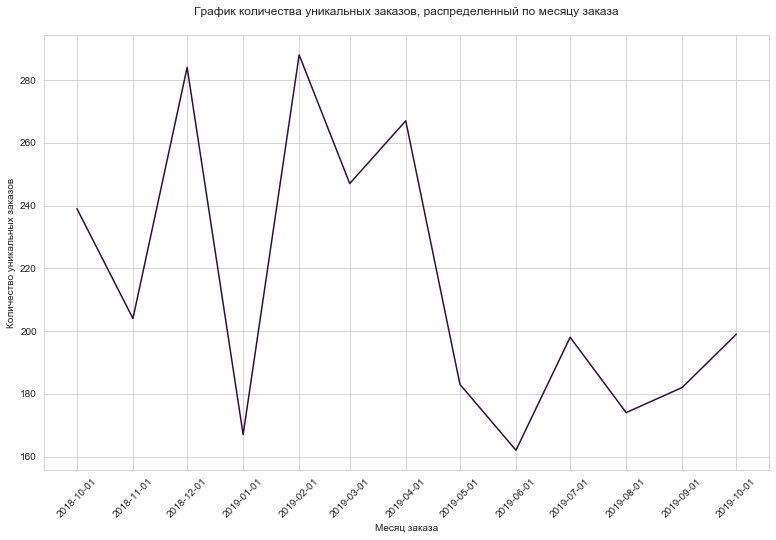

In [47]:
# График количества уникальных заказов, распределенный по месяцу заказа
plt.figure(figsize=(13, 8))
sns.lineplot(data = df.groupby('month')['order_id'].nunique());

# Настройка графика
plt.title('График количества уникальных заказов, распределенный по месяцу заказа', pad = 20)
plt.xlabel('Месяц заказа')         
plt.xticks(df['month'].unique(), rotation = 45)
plt.ylabel('Количество уникальных заказов')

plt.show()

Можно отметить, что наибольшее количество заказов совершается в декабре (возможно влияние предновогоднего периода - пользователи покупают в магазине подарки), а также с февраля по апрель (преддачный период - закупка рассады и сопутствующих  товаров). В летний и осенний периоды количество заказов снижается.   
Также можно отметить снижение количества заказов за октябрь 2019 года по сранению с октябрем 2018 года (возможно, за октябрь 2019 год в датасете присутствуют неполные данные).

### Заказы

**Проверка уникальности идентификатора заказа**

In [48]:
# Подсчет количества уникальных пользователей для каждого заказа
temp = df.groupby('order_id')['customer_id'].nunique()

In [49]:
# Cумма заказов, где одному идентификатору заказа соответствует более 1 пользователя
(temp > 1).sum()

29

Можно отметить, что идентификаторы заказов не всегда уникальны, т.к. было найдено 29 заказов, где одному идентификатору заказа соответствуют разные идентификаторы пользователей.

In [50]:
# Сохраним идентификаторы неуникальных заказов
nonunique_orders = temp[temp > 1].index

In [51]:
# Срез данных по неуникальным номерам заказав
df.query('order_id in @nonunique_orders').sort_values(by = 'order_id').head(20)

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price
3839,5518,2019-06-21,4e861452-b692-48dc-b756-99a130b7a70a,14872,"Однолетнее растение Петуния махровая в кассете 4 шт, Россия",2,82.0,22,2019-06-01,6,Растения и рассада,164.0
3841,5520,2019-06-21,4e861452-b692-48dc-b756-99a130b7a70a,14872,Петуния махровая рассада однолетних цветов в кассете по 6 шт,1,128.0,22,2019-06-01,6,Растения и рассада,128.0
3843,5549,2019-06-24,9897ccd6-9441-4886-b709-b06361fabf6c,14872,"Однолетнее растение Петуния махровая в кассете 4 шт, Россия",2,82.0,09,2019-06-01,6,Растения и рассада,164.0
3844,5550,2019-06-24,9897ccd6-9441-4886-b709-b06361fabf6c,14872,"Однолетнее растение Петуния простая в кассете по 4 шт, Россия",1,82.0,09,2019-06-01,6,Растения и рассада,82.0
3845,5551,2019-06-24,9897ccd6-9441-4886-b709-b06361fabf6c,14872,Петуния махровая рассада однолетних цветов в кассете по 6 шт,1,128.0,09,2019-06-01,6,Растения и рассада,128.0
3840,5519,2019-06-21,4e861452-b692-48dc-b756-99a130b7a70a,14872,"Однолетнее растение Петуния простая в кассете по 4 шт, Россия",1,82.0,22,2019-06-01,6,Растения и рассада,82.0
458,512,2018-10-28,0b5ce2c7-acef-4a9a-b821-61a44ed05557,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0,22,2018-10-01,10,Товары для ванной комнаты,374.0
470,538,2018-10-30,c1dd5c0e-51db-4a5d-91a3-5374cb20043d,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0,21,2018-10-01,10,Товары для ванной комнаты,374.0
1011,1154,2018-12-10,2f955596-4b13-432e-93f3-6433395aafe6,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъярусная,1,164.0,12,2018-12-01,12,Хозяйственные товары,164.0
1016,1160,2018-12-10,e3805ccd-2d64-4d0e-92dd-902293555c35,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъярусная,1,164.0,16,2018-12-01,12,Хозяйственные товары,164.0


In [52]:
# Доля неуникальных заказов
(temp > 1).sum() / df['order_id'].nunique()

0.010416666666666666

In [53]:
# Количество дублирующихся записей для неуникальных заказов
df.query('order_id in @nonunique_orders').groupby('order_id')['customer_id'].nunique()

order_id
14872    2
68785    2
69283    2
69310    2
69345    2
69410    2
69485    3
69531    2
69833    2
70114    2
70542    2
70631    2
70726    2
70808    2
70903    2
70946    2
71054    2
71226    2
71461    2
71480    3
71542    2
71571    2
71648    2
71663    2
72188    2
72778    2
72790    2
72845    4
72950    2
Name: customer_id, dtype: int64

У заказов помимо пользователей отличается время заказа, иногда год заказа, но составы заказов совпадают.

Очень похоже, что в системе присутствуют какие-то ошибки при записи заказов в базу, что приводит к неуникальности идентификаторов заказов. Необходимо разобратья с данной ошибкой на примере выделенных идентификаторов заказов (`nonunique_orders`). 

Т.к. таких заказов всего 1 процент и в основном для каждого такого заказа только один возможный дубль, будем считать, что ошибки в таких заказах не повлияют на исследование.

**Количество уникальных позиций в заказах**

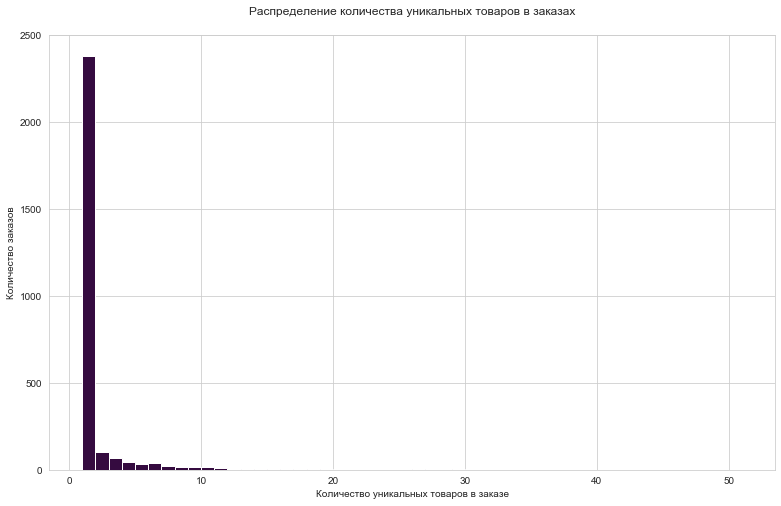

In [54]:
# График распределения количества уникальных товаров в заказах
df.groupby('order_id').agg({'product':'nunique'}).hist(bins = 50, figsize=(13, 8))

# Настройка графика
plt.title('Распределение количества уникальных товаров в заказах', pad = 20)
plt.xlabel('Количество уникальных товаров в заказе')
plt.ylabel('Количество заказов')


plt.show()

В основном в одном заказе не более 10 товаров, однако есть исключения. Тем не менее, кажется, что количество товаров в заказе находится в пределах разумного и данные выбросы не являются ошибками сбора данных.  
Проверим заказ с максимальным количеством уникальных товаров в заказе.

In [55]:
# Содержимое заказа с максимальным количеством уникальных товаров в заказе
df[df['order_id'] == int(df.groupby('order_id').agg({'product':'nunique'}).idxmax())]

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price
2732,3195,2019-04-27,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698,Земляника садовая Хоней d-9 см P9,1,75.0,16,2019-04-01,4,Растения и рассада,75.0
2733,3196,2019-04-27,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698,"Колокольчик персиколистный белый объем 0,5 л",1,105.0,16,2019-04-01,4,Растения и рассада,105.0
2734,3197,2019-04-27,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698,Пиретрум Робинсон красный объем 1 л,1,112.0,16,2019-04-01,4,Растения и рассада,112.0
2735,3198,2019-04-27,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698,Рассада зелени для кухни Лаванда Блю Райдер диам. 9 см,1,120.0,16,2019-04-01,4,Товары для кухни,120.0
2736,3199,2019-04-27,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698,Рассада зелени для кухни Лаванда Прованc диам. 9 см,1,120.0,16,2019-04-01,4,Товары для кухни,120.0
2737,3200,2019-04-27,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698,Рассада зелени для кухни Лаванды в горшке диам. 9 см,1,120.0,16,2019-04-01,4,Товары для кухни,120.0
2738,3201,2019-04-27,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698,Рассада зелени для кухни Розмарина в горшке диам. 9 см,1,120.0,16,2019-04-01,4,Товары для кухни,120.0
2739,3202,2019-04-27,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698,Рассада клубники Зенга Зенгана в кассете по E6,1,285.0,16,2019-04-01,4,Растения и рассада,285.0
2740,3203,2019-04-27,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698,Рассада клубники Зенга Зенгана горшок 9х9 см P9,1,75.0,16,2019-04-01,4,Растения и рассада,75.0
2741,3204,2019-04-27,d3b9ffea-d143-4747-8d59-74ab843d1ad6,14698,"томата (помидор) ""Золотая канарейка"" №32 сорт индетерминантный среднеспелый желтый",1,38.0,16,2019-04-01,4,Растения и рассада,38.0


Никаких аномалий не замечено. Кажется, что это просто большая закупка рассады перед дачным сезоном.

### Категории продуктов

Посмотрим распределение товаров в заказах по категориям

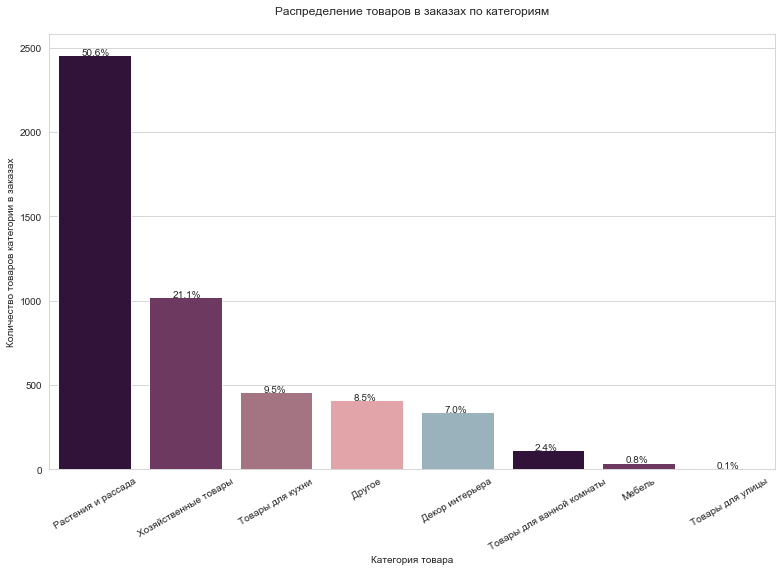

In [56]:
# Настройки фигуры 
plt.figure(figsize=(13, 8))

ax = sns.countplot(data = df, 
                   x = 'product_category',
                   order = df['product_category'].value_counts().index, palette = new);

# Процентное соотношение
total = len(df)
for p in ax.patches:
        percentage = '{:.1%}'.format(p.get_height()/total)
        x = p.get_x() + p.get_width()/3.1
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))

# Настройка графика
plt.title('Распределение товаров в заказах по категориям', pad = 20)
plt.xlabel('Категория товара')
plt.xticks(rotation = 30)
plt.ylabel('Количество товаров категории в заказах')


plt.show()

Наибольшей популярностью в магазине пользуются товары категории `Растения и рассада` (50,6%), количество товаров данной категории  в заказах превышает количество товаров других категорий вместе взятых. 

### Численные характеристики: количество товаров одного типа в корзине, цена товара, полная цена товара с учетом количества позиций в корзине пользователя, полная стоимость заказа.

Проверим, есть ли выбросы в числовых характеристиках заказов.  
Для этого для каждого такого показателя построим графики распределения и посмотрим на характеристики распределений.

In [57]:
# Список численных характеристик
numeric_features = ['price', 'quantity', 'total_price']

In [58]:
# Характеристики распределений
for i in numeric_features: 
    print('Характеристики распределения {}:'.format(i))
    print()
    print(df[i].describe())
    print()

Характеристики распределения price:

count     4851.000000
mean       516.063698
std        946.096518
min          9.000000
25%         90.000000
50%        150.000000
75%        502.000000
max      14917.000000
Name: price, dtype: float64

Характеристики распределения quantity:

count    4851.000000
mean        2.833643
std        17.642900
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

Характеристики распределения total_price:

count      4851.000000
mean        851.496805
std        9829.373066
min           9.000000
25%         120.000000
50%         194.000000
75%         734.000000
max      675000.000000
Name: total_price, dtype: float64



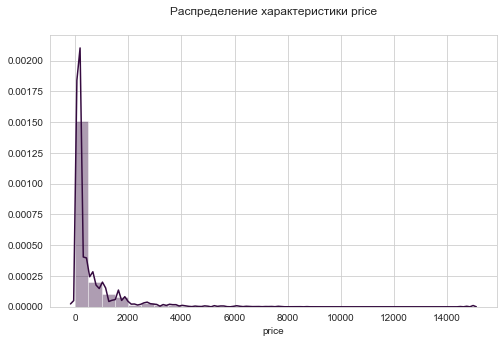

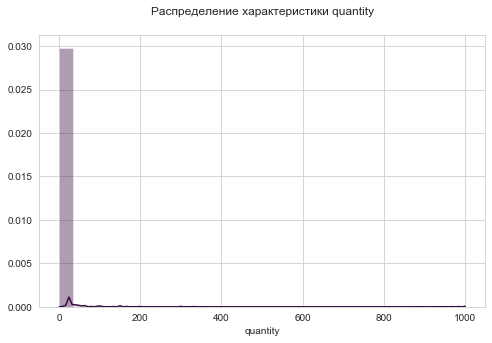

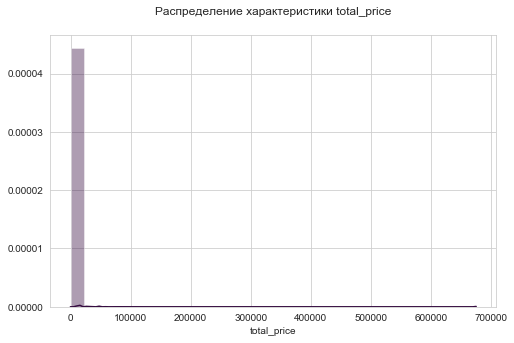

In [59]:
# Графики распределений
for i in numeric_features:   
    plt.figure(figsize=(8, 5))
    sns.distplot(df[i], bins=30)
    plt.title('Распределение характеристики {}'.format(i), pad = 20)
    plt.show()

На графиках заметно, что для всех характеристик есть существенные выбросы, которые могут повлиять на конечные результаты работы. Ислледуем данные выбросы отдельно для цен и количества товаров.

**Цена за единицу товара**

Посмотрим все заказы для 99% квантиля распределения цены за единицу товара, отсортированные по убыванию цены.

In [60]:
df[df['price'] >= df['price'].quantile(q = 0.99)].sort_values(by = 'price', ascending = False)

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price
4197,5992,2019-07-29,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,14917.0,17,2019-07-01,7,Хозяйственные товары,14917.0
2302,2697,2019-04-05,c0c60544-3a99-49d0-8a8e-cf7f293c22cb,71035,"Сумка-тележка хозяйственная Andersen Royal Shopper, Hera, синяя 166-004-90",1,8737.0,19,2019-04-01,4,Хозяйственные товары,8737.0
1701,1981,2019-02-24,ac250053-a236-467a-97d2-ddbb9bf4a1ba,70423,"Сумка-тележка хозяйственная Andersen Alu Star Shopper, Hava, синяя 115-103-90",1,8437.0,10,2019-02-01,2,Хозяйственные товары,8437.0
2554,2997,2019-04-21,19d904d8-8d16-476d-8f66-b2a3b7a23660,71227,Сумка-тележка хозяйственная Rolser MNB019 rojo LOGIC DOS+2 красная,1,8077.0,16,2019-04-01,4,Хозяйственные товары,8077.0
4763,6629,2019-10-16,d5584388-ffbe-42fd-a746-a98828ec919f,72992,Стремянка 7 ступенчатая Hailo 8040-707 XXL 13 см алюминиевая с лотком для инструментов,1,7724.0,15,2019-10-01,10,Хозяйственные товары,7724.0
4198,5994,2019-07-30,e2fe6b48-1955-4882-925c-733f545df026,72140,Сумка-тележка хозяйственная Rolser MNB017 fucsia LOGIC DOS+2 фуксия,1,7679.0,01,2019-07-01,7,Хозяйственные товары,7679.0
1995,2339,2019-03-14,27d4ce42-352b-4756-bf5b-8724e05d5131,70740,Сумка-тележка хозяйственная Rolser IMX006 bassi Logic Tour бордовая,1,7679.0,18,2019-03-01,3,Хозяйственные товары,7679.0
568,654,2018-11-05,fc333417-1d11-4a2a-b946-0957ae0603e9,68872,Сумка-тележка хозяйственная Rolser MOU041 malva RD6 сиреневая,1,7597.0,22,2018-11-01,11,Хозяйственные товары,7597.0
1084,1241,2018-12-17,86c97bf1-c834-423e-9e38-8acda68f97e8,69417,Гладильная доска Leifheit AirBoard Compact M Plus 120х38 см малиновый 71630,1,7424.0,17,2018-12-01,12,Хозяйственные товары,7424.0
4360,6169,2019-08-23,8d85f320-5f55-4647-814c-da1a6b21c2a4,72381,Урна уличная стальная Сальвадор 02.021.0 46х110 см,1,7349.0,12,2019-08-01,8,Товары для улицы,7349.0


Никаких аномалий для цен за единицу товара не выявлено, данные адекватны и соответствуют действительности, в дополнительной обработке не нуждаются.

**Количество однотипных товаров в корзине `quantity`** 

В соответствии с характеристиками распределения можно отметить, что в 75% случаев количество однотипных товаров в корзине равно 1.   
Посмотрим все заказы для 99% квантиля, отсортированные по убыванию количества однотипных товаров в корзине.

In [61]:
df[df['quantity'] >= df['quantity'].quantile(q = 0.99)].sort_values(by = 'quantity', ascending = False)

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price
3819,5456,2019-06-18,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Burstenmann, 0522/0000",1000,675.0,15,2019-06-01,6,Другое,675000.0
3751,5071,2019-06-11,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,07,2019-06-01,6,Хозяйственные товары,49432.0
3382,3961,2019-05-20,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,21,2019-05-01,5,Декор интерьера,15300.0
1014,1158,2018-12-10,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,14,2018-12-01,12,Другое,5800.0
485,568,2018-11-01,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,08,2018-11-01,11,Декор интерьера,8670.0
197,211,2018-10-11,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0,14,2018-10-01,10,Другое,2850.0
198,212,2018-10-11,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Пружина дверная 240 мм оцинкованная (Д-19 мм) без крепления, 1107014",150,38.0,14,2018-10-01,10,Другое,5700.0
2073,2431,2019-03-23,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0,10,2019-03-01,3,Другое,3000.0
503,586,2018-11-02,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0,11,2018-11-01,11,Декор интерьера,8260.0
4825,6707,2019-10-28,018fb729-3525-4314-8e4d-1982b1062f9f,73110,"Шпингалет 80 мм белый с пружиной, 1102188",100,44.0,10,2019-10-01,10,Другое,4400.0


Данные заказы похожи на оптовые закупки: количество однотипных товаров явно свидетельствует о том, что товары приобретаются  не для личного использования, а для предпринимательской деятельности.   
Такие заказы необходимо выделить в отдельную таблицу и изучать отдельно от других заказов, т.к. для них характерны совсем другие численные порядки бизнес-показателей, а также отличаются цели пользователей и, соответственно, их профили.

*В дальнейшем лучше таким товарам проставлять признак оптовых покупок и хранить их отдельно.*

Выделим список идентификаторов заказов, похожих на оптовые закупки. После чего разобьем исходный датасет на два: один с данными по оптовым заказам, второй - все оставшиеся заказы.

In [62]:
# Сохранение среза в переменную
opt = df[df['quantity'] >= df['quantity'].quantile(q = 0.99)].sort_values(by = 'quantity', ascending = False) 

# Список идентификаторов заказов c большим количеством однотипных товаров в корзине
opt_orders = opt['order_id'].unique()

In [63]:
# Таблица с данными по оптовым заказам
opt_df = df.query('order_id in @opt_orders')
opt_df.sample(5)

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price
4653,6505,2019-10-03,0309d37c-ab5f-4793-ba72-5484c019b840,72845,Муляж Яблоко зеленый 9 см полиуретан,40,59.0,15,2019-10-01,10,Декор интерьера,2360.0
2206,2598,2019-04-02,aaafc0ca-1fd4-4d0b-b7b8-37391c319fd3,70970,"Ковш пластмассовый Полимербыт С215, 1,5 л 1406006",59,64.0,09,2019-04-01,4,Другое,3776.0
1150,1316,2018-12-23,24c0b355-53e3-428a-b299-e1627b1cdd5c,69524,Муляж Яблоко зеленый 9 см полиуретан,40,59.0,11,2018-12-01,12,Декор интерьера,2360.0
3494,4082,2019-05-28,f9d19e1d-9414-485b-9d8d-02bc196a88e8,71539,"Насадка на валик ВММ-200/60 белый искусственный мех, 0703011",70,22.0,13,2019-05-01,5,Другое,1540.0
1014,1158,2018-12-10,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,14,2018-12-01,12,Другое,5800.0


Проверим, попали ли в данную выборку одиночные товары в заказах.

In [64]:
opt_df[opt_df['quantity'] < 10]['order_id'].unique()

array([69156, 69194], dtype=int64)

Найдено 2 таких заказа, выведем все строки по найденным заказам.

In [65]:
for i in opt_df[opt_df['quantity'] < 10]['order_id'].unique():
    display(df[df['order_id'] == i])

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price
896,1022,2018-11-29,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Кухонные ножницы WEBBER из нержавеющей стали с орехоколом ВЕ-5208,2,127.0,17,2018-11-01,11,Товары для кухни,254.0
897,1023,2018-11-29,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Набор ножей Attribute CHEF 5 предметов AKF522,64,457.0,17,2018-11-01,11,Товары для кухни,29248.0
898,1024,2018-11-29,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,"Нож кухонный для мяса с пластмассовой ручкой 305 х 175 мм, ""Русская Линия"" (НХ-36М), Метиз 1519003",6,127.0,17,2018-11-01,11,Товары для кухни,762.0
899,1025,2018-11-29,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,"Нож кухонный для овощей с деревянной ручкой 318 х 200 мм, ""Гурман"" (НХ-14М), Метиз 1519009",3,142.0,17,2018-11-01,11,Товары для кухни,426.0
900,1026,2018-11-29,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,"Нож кухонный универсальный с пластмассовой ручкой 285 х 150 мм, ""Русская Линия"" (НХ-38М) Метиз 1519022",24,119.0,17,2018-11-01,11,Товары для кухни,2856.0
901,1027,2018-11-29,8fba3604-ef57-4b9f-b2fe-3402fa8825c8,69156,Рыбочистка с деревянной ручкой с ножом 1518024,2,67.0,17,2018-11-01,11,Товары для кухни,134.0


,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price
958,1092,2018-12-04,b0f1833c-0763-4f4e-b097-41d27a521e46,69194,Кружка НОРДИК 380мл прозрачная H8502 Luminarc Франция,30,58.0,05,2018-12-01,12,Товары для кухни,1740.0
959,1093,2018-12-04,b0f1833c-0763-4f4e-b097-41d27a521e46,69194,"Чайник электрический АКСИНЬЯ КС-1002 корпус из жаропрочного стекла белый 2000 Вт 1,8 л",1,1087.0,05,2018-12-01,12,Растения и рассада,1087.0


Данные в таблицах подтверждают нашу гипотезу о том, что эти товары скорее всего закупаются с целью использования их в предпринимательской деятельности или перепродажи. Заказ с идентификатором `69156` похож на закупку для магазина ножей или для заведения общественного питания. Заказ с идентификатором `69194` похож на закупку для кафе или хостела.

In [66]:
# Таблица с розничными заказами
retail_df = df.query('order_id not in @opt_orders')

In [67]:
# Проверка корректности разделения данных
len(retail_df) + len(opt_df) == len(df)

True

**Цена товара в корзине с учетом количества позиций: `total price`**

Посмотрим, как поменялось распределение для розничных заказов после выделения оптовых заказов в отдельную таблицу.

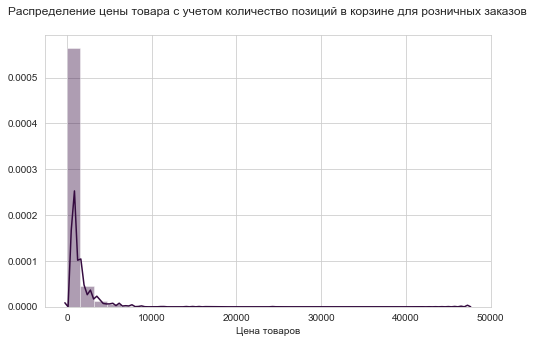

In [68]:
plt.figure(figsize=(8, 5))
sns.distplot(retail_df['total_price'], bins=30)
plt.title('Распределение цены товара с учетом количество позиций в корзине для розничных заказов', pad = 20)
plt.xlabel('Цена товаров')
plt.show()

Посмотрим заказы для 99% квантиля.

In [69]:
retail_df[retail_df['total_price'] >= retail_df['total_price'].quantile(q = 0.99)]\
    .sort_values(by = 'total_price', ascending = False)

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price
1302,1518,2019-01-15,58a4c3cc-504f-43ea-a74a-bae19e665552,69830,Простынь вафельная 200х180 см WELLNESS RW180-01 100% хлопок,27,1755.0,13,2019-01-01,1,Растения и рассада,47385.0
571,661,2018-11-06,1b2764ad-9151-4051-a46a-9b01b62e6335,68878,"Урна уличная ""Гео"", Hobbyka/Хоббика, 59*37,5см, сталь",5,4874.0,12,2018-11-01,11,Товары для улицы,24370.0
1435,1675,2019-02-04,909564b8-3a5c-4d3e-8310-5ba1c837bbd7,70080,Мусорный контейнер Hailo BigBin Swing 45 0845-010 45 л хром,3,5512.0,06,2019-02-01,2,Другое,16536.0
2538,2971,2019-04-19,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71206,Одеяло Wellness T142 белое темостеганое 140х205 см чехол 100% полиэстер 200 г/м 4690659000306,10,1568.0,19,2019-04-01,4,Другое,15680.0
4197,5992,2019-07-29,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400 40 м 175х237х237 см зеленая,1,14917.0,17,2019-07-01,7,Хозяйственные товары,14917.0
2537,2970,2019-04-19,498f12a4-6a62-4725-8516-cf5dc9ab8a3a,71205,"Наматрацник Natures Бархатный бамбук ББ-Н-1-2 односпальный, 100% хлопок, стеганый 90х200 см, с резинкой по углам, белый",12,1183.0,18,2019-04-01,4,Растения и рассада,14196.0
3647,4435,2019-06-04,940c175f-ea87-44e0-9e16-0a3d0a9abecd,71598,Скатерть круглая d-175 см 50% полиэстер 50% хлопок белая Wellness MLd-187-Эстель*01,10,1140.0,07,2019-06-01,6,Декор интерьера,11400.0
1484,1728,2019-02-07,af4d270b-c7ae-4af5-9582-4e61ff08eff0,70135,"Веник сорго с деревянной ручкой с 4-мя швами, Rozenbal, R206204",20,550.0,09,2019-02-01,2,Растения и рассада,11000.0
351,375,2018-10-23,4d93d3f6-8b24-403b-a74b-f5173e40d7db,68727,"Веник сорго с деревянной ручкой с 4-мя швами, Rozenbal, R206204",17,530.0,11,2018-10-01,10,Растения и рассада,9010.0
3769,5162,2019-06-12,940c175f-ea87-44e0-9e16-0a3d0a9abecd,71685,Скатерть 180 см WELLNESS WTd180-Лион*01 100% полиэстер,8,1104.0,09,2019-06-01,6,Декор интерьера,8832.0


Часть заказов в данном срезе также похожи на оптовые, т.к. в личных целях такие товары не покупаются в больших количествах или даже в количестве больше 1-2. 

Выделим из этого среза заказы, похожие на оптовые (количество однотипных товаров в корзине больше 2), добавим информацию по ним к таблице с оптовыми заказами и удалим по ним данные из таблицы с розничными заказами.

In [70]:
# Формирование среза данных
opt2 = retail_df[retail_df['total_price'] >= retail_df['total_price'].quantile(q = 0.99)]\
    .sort_values(by = 'total_price', ascending = False)
opt2 = opt2[opt2['quantity'] > 2]

In [71]:
# Дополнение списка оптовых заказов
opt_orders = np.append(opt_orders, opt2['order_id'].unique())

In [72]:
# Обновление таблицы с данными по оптовым заказам 
opt_df = df.query('order_id in @opt_orders')
# Обновление таблицы с данными по розничным заказам 
retail_df = df.query('order_id not in @opt_orders')

In [73]:
# Проверка корректности разделения данных
len(retail_df) + len(opt_df) == len(df)

True

**Полная стоимость заказа**

Проверим распределение полной стоимость заказов.

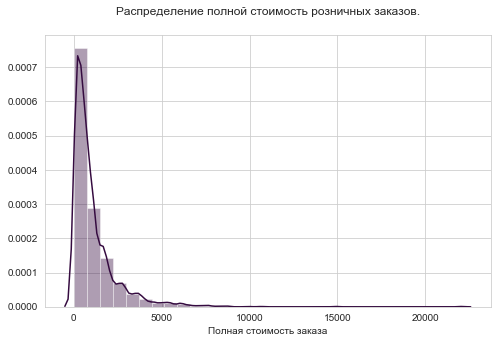

In [74]:
retail_orders = (retail_df.groupby('order_id').agg({'total_price':'sum'}))

plt.figure(figsize=(8, 5))
sns.distplot(retail_orders, bins=30)
plt.title('Распределение полной стоимость розничных заказов.', pad = 20)
plt.xlabel('Полная стоимость заказа')
plt.show()

Для данной характеристики заказа также наблюдаются большие выбросы.   
Изучим дорогие заказы, отобрав идентификаторы заказов, стоимостью больше `15 000`. 

In [75]:
expensive_orders = retail_orders[retail_orders['total_price'] > 15000].index
for i in expensive_orders:
    display(retail_df[retail_df['order_id'] == i])
    print()

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price
389,416,2018-10-26,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Вешалка деревянная с расширенными плечиками и перекладиной 44,5х23 см см серый JAPANESE BLACK VALIANT JB-19708",8,262.0,13,2018-10-01,10,Хозяйственные товары,2096.0
390,417,2018-10-26,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка для блузок 41 см черный Attribute AHM791,9,50.0,13,2018-10-01,10,Хозяйственные товары,450.0
391,418,2018-10-26,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Вешалка с закругленными плечиками без перекладины с противоскользящим покрытием Valiant 226B10 черный,7,106.0,13,2018-10-01,10,Хозяйственные товары,742.0
392,419,2018-10-26,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Гладильная доска Sarayli Tamara 125x42 см,1,3074.0,13,2018-10-01,10,Хозяйственные товары,3074.0
393,420,2018-10-26,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик влаговпитывающий ребристый 50х80 см Стандарт черный 5877,1,299.0,13,2018-10-01,10,Декор интерьера,299.0
394,421,2018-10-26,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик влаговпитывающий ребристый 60х90 см Стандарт зеленый 5884,1,412.0,13,2018-10-01,10,Декор интерьера,412.0
395,422,2018-10-26,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,Коврик придверный грязеулавливающий резиновый Finger 40х60,1,284.0,13,2018-10-01,10,Декор интерьера,284.0
396,423,2018-10-26,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Короб стеллажный с крышкой большой, 30*40*25 см, EXPEDITION VALIANT, EX-BOX-LM",1,674.0,13,2018-10-01,10,Другое,674.0
397,424,2018-10-26,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Короб стеллажный с крышкой малый, 28*30*16 см, EXPEDITION VALIANT, EX-BOX-LS",3,524.0,13,2018-10-01,10,Другое,1572.0
398,425,2018-10-26,9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f,68760,"Коробка для хранения на молнии из синтетического волокна Hausmann, 35,5х20,5х13,5 см, зеленая, BB211-3",1,749.0,13,2018-10-01,10,Другое,749.0


Данный заказ также похож на оптовый заказ, в целях личного использования в таких количествах однотипные товары не закупаются.    
Дополним список идентификаторов оптовых заказов, и заново сформируем таблицы с оптовыми и розничными товарами.

In [76]:
# Дополнение списка оптовых заказов
opt_orders = np.append(opt_orders, expensive_orders)

In [77]:
# Обновление таблицы с данными по оптовым заказам 
opt_df = df.query('order_id in @opt_orders')
# Обновление таблицы с данными по розничным заказам 
retail_df = df.query('order_id not in @opt_orders')

In [78]:
# Проверка корректности разделения данных
len(retail_df) + len(opt_df) == len(df)

True

**Проверка распределений после фильтрации**

Проверим распределения количества однотипных товаров в корзине и их цен в *розничных* заказах после фильтрации данных.

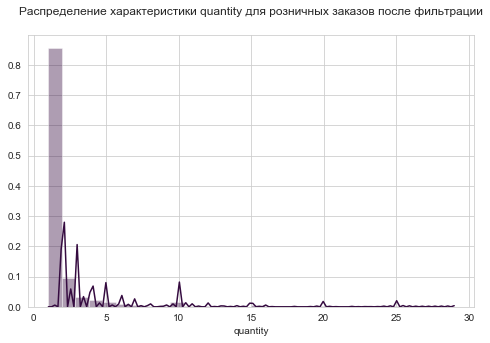

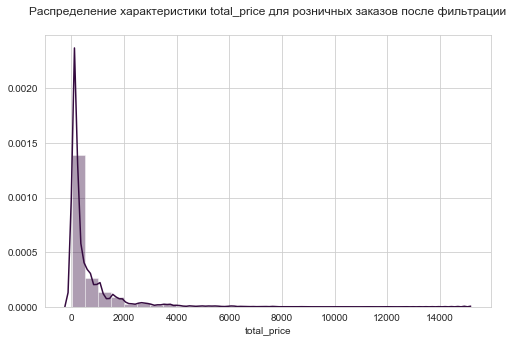

In [79]:
# Графики распределения
for i in ['quantity', 'total_price']:   
    plt.figure(figsize=(8, 5))
    sns.distplot(retail_df[i], bins=30)
    plt.title('Распределение характеристики {} для розничных заказов после фильтрации'.format(i), pad = 20)
    plt.show()

Проверим распределение полной стоимость розничных заказов.

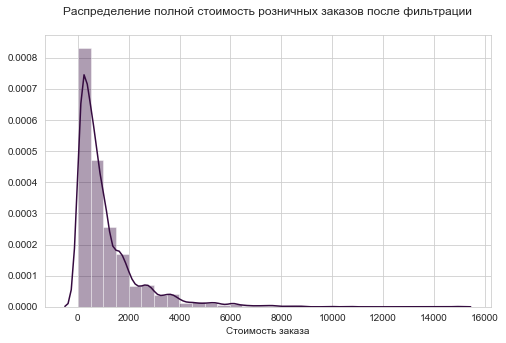

In [80]:
plt.figure(figsize=(8, 5))
sns.distplot(retail_df.groupby('order_id').agg({'total_price':'sum'}), bins=30)
plt.title('Распределение полной стоимость розничных заказов после фильтрации', pad = 20)
plt.xlabel('Стоимость заказа')
plt.show()

Проверим распределения количества однотипных товаров в корзине и их цен в *оптовых* заказах после фильтрации данных.

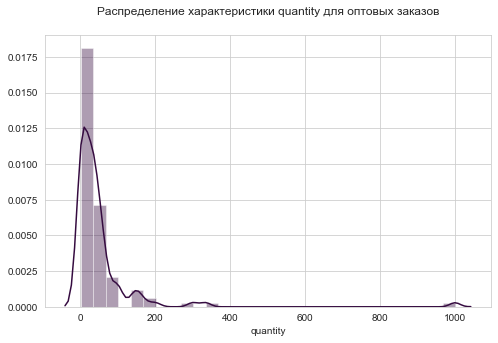

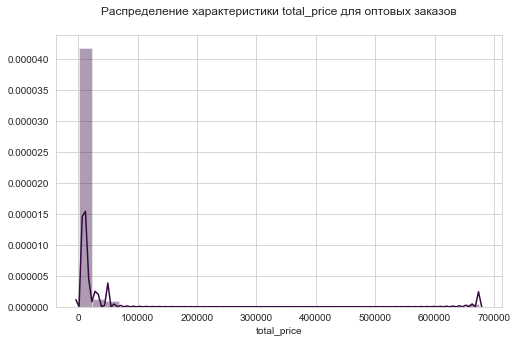

In [81]:
# Графики распределения
for i in ['quantity', 'total_price']:   
    plt.figure(figsize=(8, 5))
    sns.distplot(opt_df[i], bins=30)
    plt.title('Распределение характеристики {} для оптовых заказов'.format(i), pad = 20)
    plt.show()

Проверим распределение полной стоимость оптовых заказов.

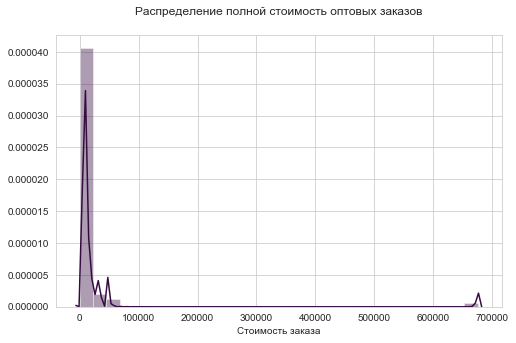

In [82]:
plt.figure(figsize=(8, 5))
sns.distplot(opt_df.groupby('order_id').agg({'total_price':'sum'}), bins=30)
plt.title('Распределение полной стоимость оптовых заказов', pad = 20)
plt.xlabel('Стоимость заказа')
plt.show()

Такие графики распределения данных лучше отображают реальную картину распределения численных характеристик заказов интернет-магазина.

### Вывод

В ходе проведения исследовательского анализа данных по заказам в интернет-магазине было обнаружено несколько аномалий и проблем с данными:
1. Ошибка с дублированием идентификаторов заказов: было найдено несколько заказов, где одному идентификатору заказа соответствуют несколько идентификаторов пользователей. Такие заказы было решено не удалять и никак не обрабатывать, т.к. нет полной уверенности, что это дубликаты, а также таких заказов всего 1 процент.
Однако необходимо найти источник ошибки, чтобы в дальнейшем не сталкиваться с такими проблемами в данных.
2. Среди заказов были найдены заказы, похожие на оптовые закупки (с учетом количества однотипных товаров в корзине, а также специфики самих товаров).  Такие заказы были выделены в отдельную таблицу `opt_df`, розничные заказы были сохранены в таблицу `retail_df`. Проводить анализ и составлять профили пользователей на всех данных сразу будет некорректным, т.к. пользователи в этих двух группах преследуют разные цели, а средние значения бизнес-показателей сильно отличаются для оптовых заказов от средних показателей для розничных заказов.

В дальнейшем в работе будет проводиться изучение поведения и сегментация розничных покупателей (анализ таблицы `retail_df`). Для оптовых покупателей будет проведен только общий анализ, т.к. по ним в исходном датасете содержится слишком мало данных для подробного анализа. Можно сказать, что заказы / пользователи в таблице opt_df составляют отдельный сегмент.


Также в процессе исследования были сделаны первые выводы относительно сезонности заказов и категорий товаров:
* был отмечен сильный рост в количестве заказов в декабре и начале весны (могут сказываться факторы предновогоднего и преддачного периодов), в летний и осенний периоды количество заказов снижается;
* наибольшей популярностью в магазине пользуются товары категории `Растения и рассада` (57%).


<a id='step3'></a>
## Расчет и изучение бизнес-метрик по розничным заказам

### Суммарная выручка 

In [83]:
total_revenue = df['total_price'].sum()
retail_revenue = retail_df['total_price'].sum()

print('Выручка по всем заказам:', total_revenue)
print('Выручка по розничным заказам:', retail_revenue)
print('Доля выручки по розничным заказам: {:.2%}'.format(retail_revenue / total_revenue))

Выручка по всем заказам: 4130611.0
Выручка по розничным заказам: 2928480.0
Доля выручки по розничным заказам: 70.90%


### Средний чек

$$Средний\ чек = \frac{Выручка}{Количество\ покупок}$$

In [84]:
print('Cредний чек: {:.2f}'.format(retail_revenue / retail_df['order_id'].nunique()))

Cредний чек: 1078.63


### Средний доход с одного пользователя (RPV)

$$RPV = \frac{Выручка}{Количество\ пользователей}$$

In [85]:
print('Средний доход с одного пользователя: {:.2f}'.format(retail_revenue / retail_df['customer_id'].nunique()))

Средний доход с одного пользователя: 1224.79


### Количество заказов на одного пользователя

Изучим, сколько заказов делает один пользователь в магазине.

In [86]:
# Количество заказов по клиентам
orders_by_customer = retail_df.groupby('customer_id').agg({'order_id':'nunique'})

In [87]:
# Характеристики распределния количества заказов на пользователя
orders_by_customer.describe()

,order_id
count,2391.000000
mean,1.147637
std,2.633140
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,124.000000


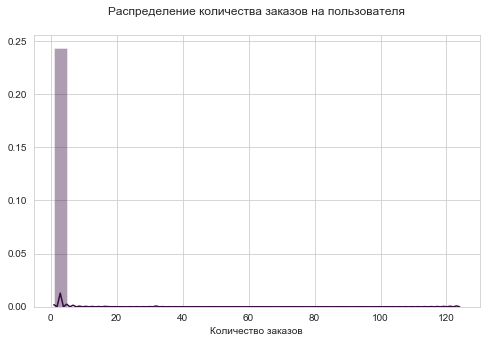

In [88]:
# График распрделения количества заказов на пользователя

plt.figure(figsize=(8, 5))
sns.distplot(orders_by_customer, bins=30)
plt.title('Распределение количества заказов на пользователя', pad = 20)
plt.xlabel('Количество заказов')
plt.show()

In [89]:
print('Среднее количество заказов на одного пользователя: {}'.format(int(orders_by_customer.mean())))
print('Доля пользователей, совершивших заказ более 1 раза: {:.1%}'
          .format(len(orders_by_customer[orders_by_customer['order_id'] > 1]) / 
                  len(orders_by_customer)
                 ))

Среднее количество заказов на одного пользователя: 1
Доля пользователей, совершивших заказ более 1 раза: 6.4%


### Средний объем корзины

Посчитаем количество уникальных продуктов в заказе

In [90]:
unique_orders_products = retail_df.groupby('order_id').agg({'product' : 'nunique'})

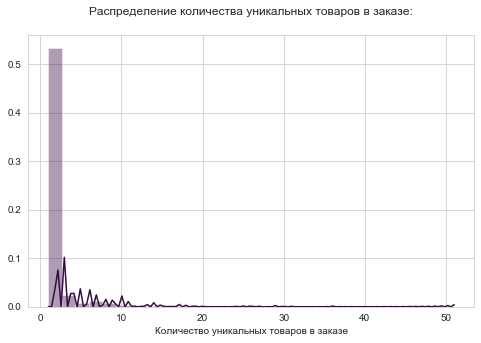

In [91]:
# График распределения количества уникальных продуктов в заказе

plt.figure(figsize=(8, 5))
sns.distplot(unique_orders_products, bins=30)
plt.title('Распределение количества уникальных товаров в заказе:', pad = 20)
plt.xlabel('Количество уникальных товаров в заказе')
plt.show()

In [92]:
print('Медианное количество уникальных товаров в заказе: {}'.format(float(unique_orders_products.median())))
print('Среднее количество уникальных товаров в заказе: {:.2f}'.format(float(unique_orders_products.mean())))

Медианное количество уникальных товаров в заказе: 1.0
Среднее количество уникальных товаров в заказе: 1.74


Посчитаем количество всех товаров в заказе:

In [93]:
count_orders_products = retail_df.groupby('order_id').agg({'quantity' : 'sum'})

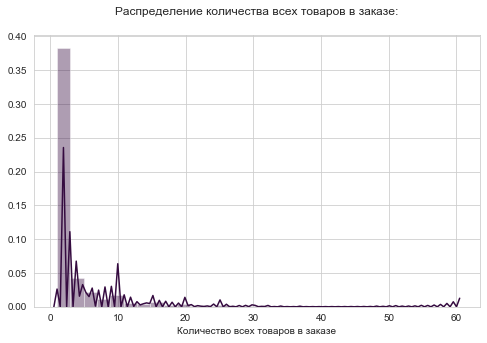

In [94]:
# График распределения количества всех продуктов в заказе

plt.figure(figsize=(8, 5))
sns.distplot(count_orders_products, bins=30)
plt.title('Распределение количества всех товаров в заказе:', pad = 20)
plt.xlabel('Количество всех товаров в заказе')
plt.show()

In [95]:
count_orders_products.describe()

,quantity
count,2715.000000
mean,3.126335
std,5.236544
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,60.000000


In [96]:
print('Медианное количество товаров в заказе: {}'.format(float(count_orders_products.median())))
print('Среднее количество товаров в заказе: {:.2f}'.format(float(count_orders_products.mean())))

Медианное количество товаров в заказе: 1.0
Среднее количество товаров в заказе: 3.13


### Выводы

Основная выручка магазина приходится на розничные продажи (составляет около `71%`).

Бизнес-метрики розничных продаж интернет-магазина за изучаемые период:
1. Средний чек пользователя составляет `1078.63`, средний доход с одного пользователя - `1224.79`.
2. В среднем пользователи делают заказ `1 раз`, всего 6,4% пользователей делают повторные заказы.
3. В среднем в корзине пользователя `1 уникальный продукт` и в сумме `3 товара`. Однако в данных есть объемные заказы, которые сильно влияют на средние значения, и если смотреть медианные значения, то у большинства пользователей в корзине только 1 товар. 


Изученные показатели подтверждают необходимость формирования персонализированных предложений для покупателей с целью увеличения количества товаров в корзине, а также для улучшения показателя возвращаемости пользователей.

<a id='step4'></a>
## Изучение оптовых заказов

Изучим общие характеристики оптовых заказов за наблюдаемый период

In [97]:
print('Доля оптовых заказов: {:.1%}'.format(opt_df['order_id'].nunique() / df['order_id'].nunique()))
print('Суммарная выручка по оптовым заказам: {}'.format(int(opt_df['total_price'].sum())))
print('Доля выручки по оптовым заказам: {:.2%}'.format(opt_df['total_price'].sum()/total_revenue))
print('Cредний чек оптового заказа: {:.2f}'.format(opt_df['total_price'].sum() 
                                                   / opt_df['order_id'].nunique()))
print('Средний доход с одного пользователя: {:.2f}'.format(opt_df['total_price'].sum() / 
                                                           opt_df['customer_id'].nunique()))

Доля оптовых заказов: 2.5%
Суммарная выручка по оптовым заказам: 1202131
Доля выручки по оптовым заказам: 29.10%
Cредний чек оптового заказа: 17422.19
Средний доход с одного пользователя: 18494.32


Изучим корзины пользователей, совершивших оптовые заказы

* Уникальность категорий оптовых запкупок

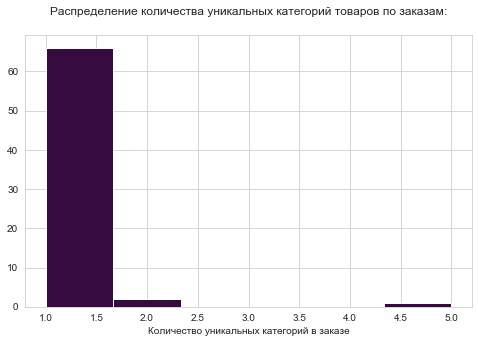

In [98]:
# График распределения количества уникальных категорий товаров по заказам

plt.figure(figsize=(8, 5))
opt_df.groupby('order_id')['product_category'].nunique().hist(bins = 6)
plt.title('Распределение количества уникальных категорий товаров по заказам:', pad = 20)
plt.xlabel('Количество уникальных категорий в заказе')
plt.show()

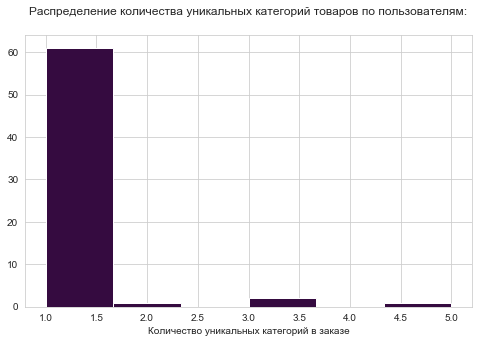

In [99]:
# График распределения количества уникальных категорий товаров по пользователям

plt.figure(figsize=(8, 5))
opt_df.groupby('customer_id')['product_category'].nunique().hist(bins = 6)
plt.title('Распределение количества уникальных категорий товаров по пользователям:', pad = 20)
plt.xlabel('Количество уникальных категорий в заказе')
plt.show()

* Объем корзины

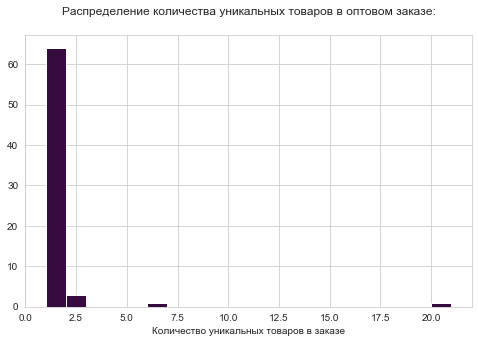

In [100]:
# График распределения количества уникальных товаров в оптовом заказе

opt_df.groupby('order_id').agg({'product' : 'nunique'}).hist(bins = 20, figsize=(8, 5))
plt.title('Распределение количества уникальных товаров в оптовом заказе:', pad = 20)
plt.xlabel('Количество уникальных товаров в заказе')
plt.show()

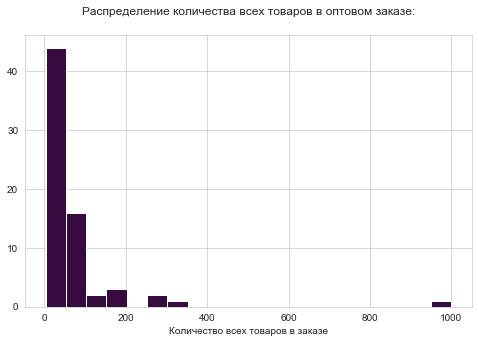

In [101]:
# График распределения количества всех товаров в оптовом заказе

opt_df.groupby('order_id').agg({'quantity' : 'sum'}).hist(bins = 20, figsize=(8, 5))
plt.title('Распределение количества всех товаров в оптовом заказе:', pad = 20)
plt.xlabel('Количество всех товаров в заказе')
plt.show()

### Вывод

По оптовым заказам за изучаемый период в таблице содержится очень мало данных, чтобы делать окончательные выводы (оптовые заказы составляют ~ 2.5% от общего числа заказов). 

На основе имеющихся данных можно выделить следующие отличительные особенности оптовых заказов:
1. Средний чек оптового заказа более чем в 15 раз превышает средний чек розничных заказов и составляет ~ `17422.19`. Однако из-за небольшого количества таких заказов, доля выручки от оптовых заказов составляет всего ~ 29%.   

2. Пользователям, совершающим оптовые заказы, свойственно покупать товары одной категории. Логично предположить, что категория товара связана с видом предпринимательской деятельности пользователя. Изучая составы корзин оптовых заказов на этапе исследовательского анализа данных, можно было заметить, что оптовые заказы состоят из однотипных товарах (например, кухонных принадлежностей, строительных материалов, рассады и т.д.)

Для данной категории пользователей можно использовать следующие подходы к формированию персонализированных предложений:
* определить сферу предпринимательской деятельности (на основе сформированной корзины или спрашивать пользователя при регистрации/оформлении заказа) и предлагать соответствующие товары со скидкой при заказе от какого-то количества единиц товара;
* на основании добавленных в корзину товаров предлагать аналогичные товары других производителей;
* проанализировать корзины оптовых покупателей, определить наиболее часто соседствующие товары, объединить их в группы, и при добавлении одного товара из группы, предлагать пользователю другие товары данной группы.

<a id='step5'></a>
## Сегментирование розничных покупателей на основе сезонности

На этапе исследовательского анализа был сделан вывод, что количество заказов вырастает в декабре, а также с февраля по апрель, в остальное время года продажи относительно одинаковые.  
Была сформулирована гипотеза, что на рост продаж влияют новогодние праздники, а также период проведения посадочных работ, соответственно в разные периоды будет различаться специфика товаров в заказах, а также целевая аудитория магазина.

Проверим данную гипотезу: 
* выделим три типа заказов:
    1. с октября по январь (осенне-зимний период, включающий новогодние праздники) - `season 1`,
    2. с февраля по апрель (посадочный период) - `season 2`,
    3. с мая по сентябрь  (дачный сезон) - `season 3`;
* изучим корзины заказов,
* изучим основные бизнес-показатели выделенных сегментов,
* проверим значимость различий в показателя среднего чека между выделенными типами заказов.


Необходимо учесть, что в таблице хранятся данные по заказам за октябрь 2018 и 2019 годов, по остальным месяцам данные только за один год.

### Определение сезона

In [102]:
# Словарь с выделенными сезонами
purchase_seasons = {1: [10, 11, 12, 1], 2: range(2, 5), 3: range(5, 10)}

In [103]:
# Функция определения сезона для значения в столбце таблицы
def assign_purchase_season(column):
    for season, month in purchase_seasons.items():
        for i in month:
            if column == i:
                return(season)
            
# Применение функции
retail_df['purchase_season'] = retail_df['month_number'].apply(assign_purchase_season)

# Проверка
retail_df[['month_number', 'purchase_season']].sample(5)

C:\Users\asfil\anaconda3\envs\practicum\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,month_number,purchase_season
4634,10,1
2763,4,2
1983,3,2
363,10,1
644,11,1


In [104]:
#Распределение количества уникальных заказов по сезонам
retail_df.groupby('purchase_season')['order_id'].nunique()

purchase_season
1    1057
2     783
3     882
Name: order_id, dtype: int64

В первой группе получилось больше заказов, т.к. в нее попал октябрь (данные по октябрю в таблице хранятся за два года).

### Изучение корзин покупателей

In [105]:
# Доля товаров категории от общего числа товаров за сезон

for i in purchase_seasons.keys():
    print('Популярность категорий для сезона', i)
    display(round(retail_df[retail_df['purchase_season'] == i]['product_category'].value_counts() 
            / len(retail_df[retail_df['purchase_season'] == i]), 2))

Популярность категорий для сезона 1


Растения и рассада           0.30
Хозяйственные товары         0.29
Другое                       0.13
Декор интерьера              0.13
Товары для кухни             0.10
Товары для ванной комнаты    0.03
Мебель                       0.01
Товары для улицы             0.00
Name: product_category, dtype: float64

Популярность категорий для сезона 2


Растения и рассада           0.64
Хозяйственные товары         0.17
Товары для кухни             0.08
Другое                       0.05
Декор интерьера              0.04
Товары для ванной комнаты    0.02
Мебель                       0.01
Name: product_category, dtype: float64

Популярность категорий для сезона 3


Растения и рассада           0.60
Хозяйственные товары         0.17
Товары для кухни             0.10
Другое                       0.06
Декор интерьера              0.04
Товары для ванной комнаты    0.02
Мебель                       0.01
Товары для улицы             0.00
Name: product_category, dtype: float64

In [106]:
# Топ 5 товаров по выделенным сезонам для каждой категории товара
for i in purchase_seasons.keys():
    print('Топ 5 популярных товаров в сезоне', i)
    print()   
    for j in retail_df['product_category'].unique():
            print('для категории', j)
            temp = retail_df[(retail_df['purchase_season'] == i) & (retail_df['product_category'] == j)]['product'].value_counts()
            display(temp.sort_values(ascending = False).head())
    print()

Топ 5 популярных товаров в сезоне 1

для категории Растения и рассада


Пеларгония зональная диам. 12 см сиреневый полумахровый                                  17
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, коралловая, полумахровая    11
Герань домашняя (пеларгония зональная) цветущая , D12, H25-30, красная, махровая          9
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, белая, махровая              9
Герань домашняя (пеларгония зональная) цветущая D12, H25-30, сиреневый, простая           8
Name: product, dtype: int64

для категории Другое


Подрукавник складной Ника П                                5
Таз пластмассовый 40,0 л пищевой овальный (Иж), 1404094    4
Таз пластмассовый со стиральной доской (Иж), 1404021       4
Подкладка под чехол Zalger 520140 135х50 см поролон        4
Подкладка под чехол Zalger 520114 135х50 см войлок         3
Name: product, dtype: int64

для категории Хозяйственные товары


Сумка-тележка 2-х колесная Gimi Argo синяя                                  23
Сушилка для белья потолочная Лиана 2,4 м 1703011                             6
Сушилка для белья настенная Zalger Prima 510-720 веревочная 7 линий 25 м     6
Сушилка для белья потолочная Лиана 2,0 м 1703009                             5
Сумка для тележки большая комбинированная 45*30*25, 1209021                  5
Name: product, dtype: int64

для категории Товары для кухни


Кувшин пластмассовый с крышкой "Кумган" 2,0 л 1408003          5
Рассада зелени для кухни Розмарина в горшке диам. 9 см         5
Измельчитель овощей ручной ШК-4 деревянный, 3 ножа, 1516020    3
Ложка столовая RIPPLE сталь 3 мм, 3 шт, Attribute, ACR023      3
Вилка столовая RIPPLE сталь 3 мм, 3 шт, Attribute, ACR013      3
Name: product, dtype: int64

для категории Декор интерьера


Новогоднее дерево Ель сербская d-21 см h-60 см    8
Муляж Морковь 16 см                               7
Муляж Зеленое яблоко полиуретан d-6 см            7
Муляж Красное яблоко мини полиуретан d-6 см       6
Муляж Персики мини полиуретан d-6 см              5
Name: product, dtype: int64

для категории Товары для ванной комнаты


Штора со встроенными кольцами под штангу для ванны и душа жаккард, полиамидное покрытие, 180х200, белый, HSC/ST04/white      3
Сиденье в ванну раздвижное, белый, СВ5, НИКА                                                                                 3
Штора для ванной комнаты Bacchetta Dama текстильная 180х200 см 3655                                                          3
Штора для ванной комнаты Diamante 240х200 см бежевая, Bacchetta, 4800                                                        3
Штора со встроенными кольцами под штангу для ванны и душа жаккард, полиамидное покрытие, 180х200, бежевый, HSC/ST05/beige    3
Name: product, dtype: int64

для категории Мебель


Подставка для обуви резиновая Attribute 80x40 см AMC080                        2
Полки QWERTY Италия белый/серый 40х14х10 см 35х10х10 см 30х7х10 см 72006       2
Полки QWERTY Пекин белый/чёрный 95х17,5х16 см 40х13х16 см 40х13х16 см 72017    1
Полки QWERTY Лондон белый 27х27х10 см и 23х23х10 см 72000                      1
Полки QWERTY Торонто белый 40х10 см 35х10 см 30х10 см 25х10 см 72015           1
Name: product, dtype: int64

для категории Товары для улицы


Термометр на окно уличный на липучках Т-5 h-20 см 1210035    2
Урна уличная стальная Юпитер 02.012.0 38х38х60 см            1
Термометр уличный оконный ТБ 202 h-20 см 1210036             1
Name: product, dtype: int64


Топ 5 популярных товаров в сезоне 2

для категории Растения и рассада


Пеларгония розебудная Red Pandora укорененный черенок      38
Пеларгония розебудная Prins Nikolai укорененный черенок    30
Пеларгония розебудная Mary укорененный черенок             24
Пеларгония розебудная Margaretha укорененный черенок       22
Пеларгония зональная диам. 12 см сиреневый полумахровый    18
Name: product, dtype: int64

для категории Другое


Таз пластмассовый со стиральной доской (Иж), 1404021                                                3
Подкладка под чехол Zalger 520114 135х50 см войлок                                                  2
Чехол Eurogold Reflector с металлизированной полосой, поролон для досок 120х38-120x42 см DC42F3R    2
Чехол для костюма 60х110 см Rozenbal R261016                                                        2
Миксер электрический погружной DELTA DL-5061 белый с сиреневым 300 Вт 5 скоростей                   2
Name: product, dtype: int64

для категории Хозяйственные товары


Сумка-тележка 2-х колесная Gimi Argo синяя                                                                 10
Тележка багажная DELTA ТБР-20 черный с серым грузоподъемность 25 кг сумка 50 кг каркас РОССИЯ               7
Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ     6
Тележка багажная DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ                      6
Гладильная доска НИКА ДСП ЭКОНОМ 106,5х29 ЭК1                                                               5
Name: product, dtype: int64

для категории Товары для кухни


Рассада зелени для кухни Розмарин Блю Лагун диам. 9 см            6
Рассада зелени для кухни Мята Морокан диам. 9 см                  4
Рассада зелени для кухни Тимьян Сильвер Кинг диам. 9 см           4
Рассада зелени для кухни Душица-орегано розовый объем 0,5 л       3
Рассада зелени для кухни Мелисса лимонная зеленый объем 0,75 л    3
Name: product, dtype: int64

для категории Декор интерьера


Муляж Баклажан 18 см                                                         5
Коврик придверный хлопковый 55х110 см мультиколор, Helex, С03                3
Муляж Банан желтый 21 см полиуретан                                          3
Муляж Перец Чили в связке, красный, 60 см, полиуретан, Fancy Fair/ff RP60    2
Муляж Яблоко, оранжевый, 8,5 см, полиуретан                                  2
Name: product, dtype: int64

для категории Товары для ванной комнаты


Штанга для ванной Г-образная, угловая 80Х170 см, хром                           3
Штора для ванной комнаты Quadretto 240х200 см белая, Bacchetta, 4062            3
Карниз для ванной комнаты Виолет раздвижной 280 см с кольцами бежевый 2810/2    2
Сиденье в ванну раздвижное, белый, СВ5, НИКА                                    2
Штора для ванной комнаты Rigone 240х200 см бежевая, Bacchetta, 4059             2
Name: product, dtype: int64

для категории Мебель


Этажерка для обуви НИКА ЭТП3/З с ящиком золотой                                         2
Подставка для обуви резиновая Attribute 80x40 см AMC080                                 1
Полки QWERTY Берлин чёрный 44х24х10 см 40х20х10 см 36х16х10 см 72008                    1
Полки QWERTY Нью-Йорк правый белый/голубой 44х24х10 см 40х20х10 см 36х16х10 см 72012    1
Полки QWERTY Барселона белый 28х28х15 см 23х23х15 см 17х17х15 см 72009                  1
Name: product, dtype: int64

для категории Товары для улицы


Series([], Name: product, dtype: int64)


Топ 5 популярных товаров в сезоне 3

для категории Растения и рассада


Пеларгония розебудная Prins Nikolai укорененный черенок        27
Пеларгония розебудная Red Pandora укорененный черенок          26
Пеларгония зональная диам. 12 см сиреневый полумахровый        17
Однолетнее растение Петуния махровая в кассете 4 шт, Россия    17
Пеларгония розебудная Queen Ingrid укорененный черенок         14
Name: product, dtype: int64

для категории Другое


Таз пластмассовый со стиральной доской (Иж), 1404021      3
Овсянница сизая серый объем 1 л                           2
Чехол для костюма 60х110 см Rozenbal R261016              2
Таз пластмассовый 24,0 л пищевой круглый (Иж), 1404006    2
Таз пластмассовый 30,0 л овальный ПЦ2913, 1404051         2
Name: product, dtype: int64

для категории Хозяйственные товары


Сумка-тележка 2-х колесная Gimi Argo синяя                                                                 14
Сушилка для белья настенная Zalger Prima 510-720 веревочная 7 линий 25 м                                    7
Тележка багажная DELTA ТБР-15 цвет в ассортименте грузоподъемность 30 кг РОССИЯ                             6
Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ     6
Тележка багажная DELTA ТБР-20 синий грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ                      6
Name: product, dtype: int64

для категории Товары для кухни


Рассада зелени для кухни Тимьян-чабрец розовый объем 0,5 л    7
Рассада зелени для кухни Розмарин Блю Лагун диам. 9 см        7
Рассада зелени для кухни Розмарина в горшке диам. 9 см        7
Рассада зелени для кухни Кориандр в кассете 6 шт              6
Рассада зелени для кухни Базилик Тонус, кассета по 6шт        6
Name: product, dtype: int64

для категории Декор интерьера


Коврик хлопковый 40х60 см цвета в ассортименте 6194                                                   4
Коврик придверный хлопковый 60х140 см мультиколор, Helex, С04                                         3
Коврик хлопковый 50х80 см цвета в ассортименте 6196                                                   3
Муляж Персики мини полиуретан d-6 см                                                                  3
Коврик придверный с дизайном, из резины и кокоса 58,5*89 Gothic Iron Slice / Готический Узор, 4468    3
Name: product, dtype: int64

для категории Товары для ванной комнаты


Штанга для ванной Г-образная, угловая 80Х170 см, белая                           4
Сиденье в ванну раздвижное, белый, СВ5, НИКА                                     2
Карниз для ванной комнаты Виолет раздвижной 280 см с кольцами бежевый 2810/2     2
Штора для ванной комнаты полиэстер Dasch 180х180 см Аквамарин ВТ-822502, 5698    2
Штора для ванной комнаты Cannetto 240х200 см коричневая, Bacchetta, 4061         2
Name: product, dtype: int64

для категории Мебель


Комод Эльфпласт № 3 Алфавит оранжевый 301о                                              2
Полки QWERTY Торонто белый 40х10 см 35х10 см 30х10 см 25х10 см 72015                    2
Полки QWERTY Нью-Йорк правый белый/голубой 44х24х10 см 40х20х10 см 36х16х10 см 72012    2
Обувница-3 Квадро цвет венге 70000001в                                                  1
Этажерка для обуви ВИОЛЕТ Э2П 2 яруса медный антик                                      1
Name: product, dtype: int64

для категории Товары для улицы


Урна уличная стальная Сальвадор 02.021.0 46х110 см    1
Name: product, dtype: int64

*Категории товаров*  
1.	Ранее было отмечено, что в магазине наибольшей популярностью пользуются товары категории "Растения и рассада". Однако в осенне-зимний период (`сезон 1`) заинтересованность покупателей в товарах данной категории сильно падает. И, наоборот,  для товаров других категорий в этот период самые высокие показатели, по сравнению с другими выделенными сезонами.
Также можно отметить, что в этот период покупателей намного больше интересуют товары из категории `Декор интерьера`,  чем в другие периоды.
2.	В весенний (+февраль) и летний(+сентябрь) периоды (`сезон 2` и `сезон 3`) покупателей больше всего интересуют товары категории ` Растения и рассада `. Процент заказов по другим категориям товаров очень мал.

*Товары*
1. В `сезон 1` покупателей больше интересуют домашние растения, в то время как в  `сезон 2` и `сезон 3`  больше покупают растения для рассады.
2. В `сезон 1` большим спросом пользуются новогодний деревья.
3. В  `сезон 2` и `сезон 3` очень популярна рассада зелени для кухни.

### Бизнес-метрики по выделенным сегментам

In [107]:
df.groupby('customer_id').agg({'order_id':'nunique'}).mean()

order_id    1.149327
dtype: float64

In [108]:
# Функция, подсчитывающая основные средние значения бизнес показателей

def segment_features(df):
    print('Cредний чек: {:.2f}'.format(df['total_price'].sum() / df['order_id'].nunique()))
    print('Средний доход с одного пользователя: {:.2f}'.format(df['total_price'].sum() / df['customer_id'].nunique()))
    print('Среднее количество заказов на пользователя: {:.2f}'.format(float(df.groupby('customer_id').agg({'order_id':'nunique'}).mean())))
    print('Среднее количество уникальных товаров в корзине: {:.2f}'.format(float(df.groupby('order_id').agg({'product' : 'nunique'}).mean())))
    print('Среднее количество всех товаров в корзине: {:.2f}'.format(float(df.groupby('order_id').agg({'quantity' : 'sum'}).mean())))

In [109]:
for i in purchase_seasons.keys():
    print('Метрики для сезона {}:'.format(i))
    segment_features(retail_df[(retail_df['purchase_season'] == i)])
    print()

Метрики для сезона 1:
Cредний чек: 1159.35
Средний доход с одного пользователя: 1384.67
Среднее количество заказов на пользователя: 1.20
Среднее количество уникальных товаров в корзине: 1.47
Среднее количество всех товаров в корзине: 2.70

Метрики для сезона 2:
Cредний чек: 988.70
Средний доход с одного пользователя: 1120.33
Среднее количество заказов на пользователя: 1.14
Среднее количество уникальных товаров в корзине: 1.83
Среднее количество всех товаров в корзине: 3.51

Метрики для сезона 3:
Cредний чек: 1053.17
Средний доход с одного пользователя: 1117.80
Среднее количество заказов на пользователя: 1.07
Среднее количество уникальных товаров в корзине: 1.97
Среднее количество всех товаров в корзине: 3.28



1. Кажется, что стоимость покупок в осенне-зимний период (`сезон 1`) выше, в то время как количество заказов и покупаемых товаров меньше, чем для остальных сезонов. 
2. Наименьший средний чек в весенний период (`сезон 2`), в то время как количество заказов и количество товаров в корзине самое большое, что может говорить о том, что в этот период покупают более дешевые товары.

### Проверка гипотезы о значимости различий среднего чека выделенных сегментов

In [110]:
# Стоимость заказов в разбивке по сезонам
order_price_by_season = retail_df.groupby(['order_id', 'purchase_season'], as_index = False)['total_price'].sum()

In [111]:
# Размерность выборок
order_price_by_season.groupby('purchase_season')['order_id'].nunique() 

purchase_season
1    1057
2     783
3     882
Name: order_id, dtype: int64

In [112]:
# Процентное соотношение количества заказов в выборках
order_price_by_season.groupby('purchase_season')['order_id'].nunique() / len(order_price_by_season)

purchase_season
1    0.388317
2    0.287656
3    0.324026
Name: order_id, dtype: float64

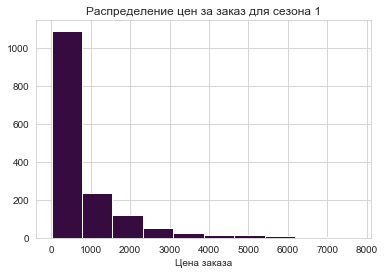

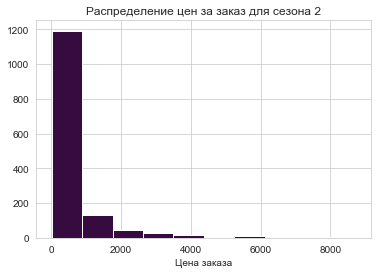

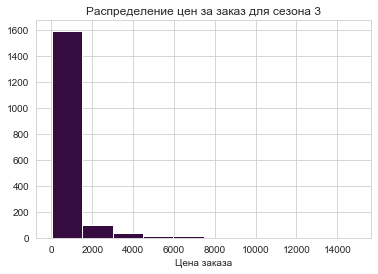

In [113]:
for i in purchase_seasons.keys():
    retail_df[retail_df['purchase_season'] == i]['total_price'].hist()
    plt.title('Распределение цен за заказ для сезона {}'.format(i))
    plt.xlabel('Цена заказа')
    plt.show()

Еще раз выведем средний чек для каждого сезона

In [114]:
order_price_by_season.groupby('purchase_season')['total_price'].mean()

purchase_season
1    1159.353832
2     988.698595
3    1053.165533
Name: total_price, dtype: float64

Для проверки гипотез будет использоваться `t-критерий Стьюдента`: использование данного типа теста обусловлено наличием двух независимых выборок количественных данных и необходимостью сравнить средние значения.

In [115]:
# Функция проведения t-теста
def t_test(s1, s2, alpha):
    results = st.ttest_ind(s1, s2, equal_var=False)
    print("P-value:", results.pvalue)
    if results.pvalue < alpha:
        print("Отвергаем H0: разница между средними чеками сегментов статистически значима")
    else:
        print("Не получается отвергнуть нулевую гипотезу: разница между средними чеками сегментов статистически незначима")

In [116]:
# Зададим значение для уровня значимости:
alpha = 0.05

Т.к. сравниваться будут три выборки (множественное сравнение), то будем использовать поправку Бонферрони для уменьшения ложноположительных результатов, т.е. уровень значимости будет равен `alpha / 3`.

**Проверка статистической значимости разницы средних чеков заказов сезона 1 и сезона 2.**

*H0: Средние чеки заказов сезона 1 и сезона 2 равны.*

In [117]:
# T-тест
t_test(order_price_by_season.query('purchase_season == 1')['total_price'],
       order_price_by_season.query('purchase_season == 2')['total_price'],
       alpha / 3)

P-value: 0.003350291830850784
Отвергаем H0: разница между средними чеками сегментов статистически значима


**Проверка статистической значимости разницы средних чеков заказов сезона 2 и сезона 3.**

*H0: Средние чеки заказов сезона 2 и сезона 3 равны.*

In [118]:
# T-тест
t_test(order_price_by_season.query('purchase_season == 2')['total_price'],
       order_price_by_season.query('purchase_season == 3')['total_price'],
       alpha / 3)

P-value: 0.29921826187739375
Не получается отвергнуть нулевую гипотезу: разница между средними чеками сегментов статистически незначима


**Проверка статистической значимости  разницы средних чеков заказов сезона 1 и сезона 3.**

*H0: Средние чеки заказов сезона 1 и сезона 3 равны.*

In [119]:
# T-тест
t_test(order_price_by_season.query('purchase_season == 1')['total_price'],
       order_price_by_season.query('purchase_season == 3')['total_price'],
       alpha / 3)

P-value: 0.07502035849254927
Не получается отвергнуть нулевую гипотезу: разница между средними чеками сегментов статистически незначима


**Проверка статистической значимости  разницы средних чеков заказов сезона 1 и сезонов 2+3.**

*H0: Средние чеки заказов сезона 1 и сезонов 2 и 3 вместе взятых равны.*

In [120]:
# T-тест
t_test(order_price_by_season.query('purchase_season == 1')['total_price'],
       order_price_by_season.query('purchase_season == 2 or purchase_season == 3')['total_price'],
       alpha / 3)

P-value: 0.006479638826308646
Отвергаем H0: разница между средними чеками сегментов статистически значима


### Выводы

*	Наиболее выгодным сезоном для магазина является осенне-зимний период (с октября по январь), т.к. средний чек розничной покупки в это время больше, чем в остальные периоды. В этот период покупателей меньше интересуют растения и рассада (ключевая категория в магазине) и больше интересуют покупки других категорий, особенно повышается интерес к категории "Декор интерьера". Из категории товаров "Растения и рассада" покупателей больше всего привлекают домашние растения.
*	В остальной период различие в среднем чеке незначительное. Покупателей больше всего интересует категория "Растения и рассада", особенно растения на посадку.

Можно предложить разделить покупателей на 2 категории:
1. Покупатели, которые совершают покупки в осенне-зимний период,
2. Покупатели, которые совершают покупки в остальные периоды.

Исходя из категории, покупателям можно предлагать особые условия покупки популярных в данный период товаров (акции по типу 2 по цене 1, купи n-товаров категории и получи 1 бесплатно, "пакеты" товаров и т.д.), сделать рекомендательную систему товаров исходя из популярности товара в данном сезоне, а также делать рассылку сезонных товаров зарегистрированным покупателям.

<a id='step6'></a>
## Сегментирование розничных покупателей на основе всех характеристик

Сегментацию клиентов выполним с использованием алгоритмов кластеризации ML:
1. подготовим таблицу с вектором признаков (набором характеристик пользователей),
2. определим оптимальное число кластеров с помощью агломеративной иерархической кластеризации,
3. выделим сегменты пользователей с помощью алгоритма кластеризации k-means,
4. изучим выделенные сегменты.

### Таблица с характеристиками пользователей

Составим таблицу с характеристиками пользователей:
   * суммарная выручка по пользователю,
   * средний чек,
   * количество заказов,
   * лайфтайм клиента (в месяцах),
   * наиболее популярная категория,
   * количество уникальных товаров в корзине,
   * общее количество товаров в корзине.

**Характеристики на основе таблицы `retail_df`**

In [121]:
# Группировка пользователей и подсчет основных бизнес-показателей
users = retail_df.groupby('customer_id').agg({'total_price':'sum', 
                                              'order_id':'nunique',
                                              'date':['min', 'max'],
                                              'product_category': pd.Series.mode,
                                               })

In [122]:
# Удаление второго уровня в названии колонок
users.columns = users.columns.droplevel(0)

In [123]:
# Переименование колонок
users = users.rename(columns={'sum' : 'revenue',
                             'nunique' : 'orders_count',
                              'min' : 'date_min',
                              'max' : 'date_max',
                              'mode' : 'popular_category'
                             })
users.head()

,revenue,orders_count,date_min,date_max,popular_category
customer_id,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,1,2019-10-16,2019-10-16,Растения и рассада
001cee7f-0b29-4716-b202-0042213ab038,442.0,1,2019-02-16,2019-02-16,Хозяйственные товары
00299f34-5385-4d13-9aea-c80b81658e1b,914.0,1,2019-10-14,2019-10-14,Другое
002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1,2019-01-27,2019-01-27,Хозяйственные товары
003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,1,2019-09-29,2019-09-29,Мебель


**Средний чек**

In [124]:
users['average_check'] = users['revenue'] / users['orders_count']
users['average_check'].describe()

count     2391.000000
mean      1070.964084
std       1276.807328
min         14.000000
25%        273.000000
50%        644.000000
75%       1349.000000
max      14917.000000
Name: average_check, dtype: float64

Средний чек, посчитанный в разбике по пользователям (по таблице `users`), незначительно отличается от среднего чека, посчитанного по таблице `retail_df`, из-за 29 идентификаторов заказов, которые одновременно указаны для разных пользователей.

**Срок жизни клиента в магазине в месяцах**

In [125]:
# Расчет разницы между минимальной и максимальной датой заказа по клиенту в месяцах
users['lifetime'] = ((users['date_max'].dt.year - users['date_min'].dt.year)*12 
                     + 
                     (users['date_max'].dt.month - users['date_min'].dt.month))
users['lifetime'].describe()

count    2391.000000
mean        0.028858
std         0.270602
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: lifetime, dtype: float64

**Корзина покупателя**

Посчитаем для каждого клиента среднее количество уникальных товаров в корзине и среднее количество всех товаров в корзине.

In [126]:
# Ггруппировка по пользователям и заказам и подсчет суммарного количества товаров по заказам
customers_orders_cart = retail_df.groupby(['customer_id', 'order_id'], as_index = False).agg({'product':'nunique',
                                                                                                  'quantity':'sum'})
customers_orders_cart.head()

,customer_id,order_id,product,quantity
0,000d6849-084e-4d9f-ac03-37174eaf60c4,14943,4,4
1,001cee7f-0b29-4716-b202-0042213ab038,70290,1,1
2,00299f34-5385-4d13-9aea-c80b81658e1b,72965,1,2
3,002d4d3a-4a59-406b-86ec-c3314357e498,69990,1,1
4,003bbd39-0000-41ff-b7f9-2ddaec152037,72796,1,2


In [127]:
# Средние значения количества товаров в корзинах по пользователям
customers_cart =  customers_orders_cart.groupby('customer_id').agg({'product':'mean',
                                                                    'quantity':'mean'})
customers_cart.head()

,product,quantity
customer_id,,
000d6849-084e-4d9f-ac03-37174eaf60c4,4.0,4.0
001cee7f-0b29-4716-b202-0042213ab038,1.0,1.0
00299f34-5385-4d13-9aea-c80b81658e1b,1.0,2.0
002d4d3a-4a59-406b-86ec-c3314357e498,1.0,1.0
003bbd39-0000-41ff-b7f9-2ddaec152037,1.0,2.0


Смержим таблицу с бизнес метриками `users` с таблицей с информацией по количеству продуктов в корзине `customers_cart` по пользователям.

In [128]:
# Исходная размерность таблиц
print(len(customers_cart))
print(len(users))

2391
2391


In [129]:
# Мерж данных по пользователям
users = users.join(customers_cart)

In [130]:
# Длина конечной таблицы
len(users)

2391

In [131]:
# Переименование названия новых столбцов
users = users.rename(columns={'product' : 'unique_products_in_cart',
                             'quantity' : 'products_in_cart'})

In [132]:
# Таблица с характеристиками пользователей
users.head()

,revenue,orders_count,date_min,date_max,popular_category,average_check,lifetime,unique_products_in_cart,products_in_cart
customer_id,,,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,1,2019-10-16,2019-10-16,Растения и рассада,555.0,0,4.0,4.0
001cee7f-0b29-4716-b202-0042213ab038,442.0,1,2019-02-16,2019-02-16,Хозяйственные товары,442.0,0,1.0,1.0
00299f34-5385-4d13-9aea-c80b81658e1b,914.0,1,2019-10-14,2019-10-14,Другое,914.0,0,1.0,2.0
002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1,2019-01-27,2019-01-27,Хозяйственные товары,1649.0,0,1.0,1.0
003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,1,2019-09-29,2019-09-29,Мебель,2324.0,0,1.0,2.0


**Обработка категориальных значений**

При использовании алгоритма кластеризации ML необходимо перевести категориальные значения в двоичные переменные по каждой категории. Всего выделено 8 категорий товаров. Добавлять 8 столбцов с двоичными данными кажется не очень хорошей идеей, т.к. будет слишком много характеристик объектов для анализа. 

Выделим две родительские категории: `plants` и `others`, т.к. в магазине в заказах более 50% товаров приходится на категорию "Растения и рассада" и оставшиеся 50% приходятся на товары остальных категорий, после чего переведем значения в двоичные переменные.

In [133]:
# Функция выделения родительский категорий
def define_parent_category(column):
    if str(column) == 'Растения и рассада':
        return 'plant'
    return 'other'

In [134]:
# Применение функции к столбцу popular_category
users['parent_category'] = users['popular_category'].apply(define_parent_category)
users.head(3)

,revenue,orders_count,date_min,date_max,popular_category,average_check,lifetime,unique_products_in_cart,products_in_cart,parent_category
customer_id,,,,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,1,2019-10-16,2019-10-16,Растения и рассада,555.0,0,4.0,4.0,plant
001cee7f-0b29-4716-b202-0042213ab038,442.0,1,2019-02-16,2019-02-16,Хозяйственные товары,442.0,0,1.0,1.0,other
00299f34-5385-4d13-9aea-c80b81658e1b,914.0,1,2019-10-14,2019-10-14,Другое,914.0,0,1.0,2.0,other


In [135]:
# Преобразование категориальных переменных в двоичные значения
users = pd.get_dummies(users[['revenue', 'orders_count', 'average_check', 'lifetime',
                              'unique_products_in_cart', 'products_in_cart', 'parent_category']])

In [136]:
# Переименование названий новых столбцов
users = users.rename(columns={'parent_category_other' : 'is_other',
                              'parent_category_plant' : 'is_plant'})


# Итоговая таблица с характеристиками (вектор признаков)
users.head()

,revenue,orders_count,average_check,lifetime,unique_products_in_cart,products_in_cart,is_other,is_plant
customer_id,,,,,,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,555.0,1,555.0,0,4.0,4.0,0,1
001cee7f-0b29-4716-b202-0042213ab038,442.0,1,442.0,0,1.0,1.0,1,0
00299f34-5385-4d13-9aea-c80b81658e1b,914.0,1,914.0,0,1.0,2.0,1,0
002d4d3a-4a59-406b-86ec-c3314357e498,1649.0,1,1649.0,0,1.0,1.0,1,0
003bbd39-0000-41ff-b7f9-2ddaec152037,2324.0,1,2324.0,0,1.0,2.0,1,0


### Определение оптимального числа кластеров

In [137]:
# Стандартизация вектора признаков
scaler = StandardScaler()
X_st = scaler.fit_transform(users)

In [138]:
# Таблица связей между объектами
linked = linkage(X_st, method = 'ward')

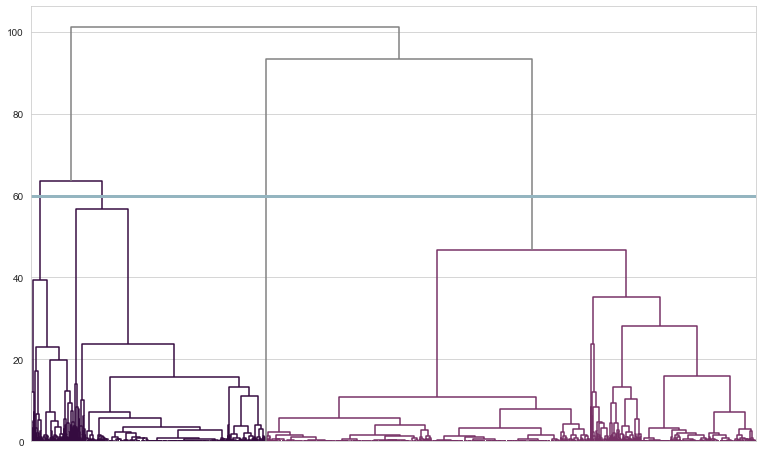

In [139]:
# Отрисовка дендрограммы
plt.figure(figsize = (13, 8))

hierarchy.set_link_color_palette(new)
dendrogram(linked, orientation = 'top', above_threshold_color="grey")

plt.axhline(60, linewidth=3, color='#94b5c0')
plt.xticks([])
plt.show()

Примем за оптимальное число кластеров - `4 кластера`.

### Сегментирование на основе алгоритма k-means

In [140]:
# Определение модели k_means с числом кластеров = 4
km = KMeans(n_clusters = 4, random_state = RANDOM_STATE)

# Прогноз кластеров для стандартизированных признаков
labels = km.fit_predict(X_st)

# Сохранение меток кластеров в новый столбец исходной таблицы
users['cluster'] = labels

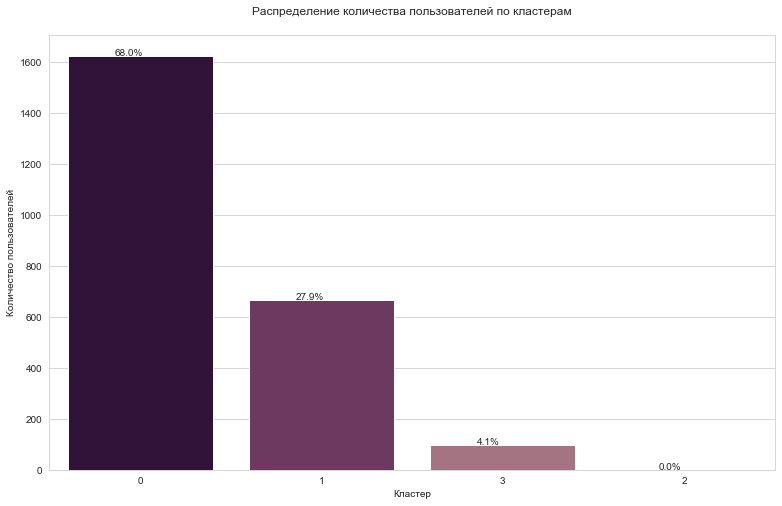

In [141]:
# Распределение количества пользователей по кластерам
plt.figure(figsize=(13, 8))

ax = sns.countplot(users['cluster'],
                   order = users['cluster'].value_counts().index,
                   palette = new);

# Процентное соотношение
total = len(users)
for p in ax.patches:
        percentage = '{:.1%}'.format(p.get_height()/total)
        x = p.get_x() + p.get_width()/3.1
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y))

# Настройка графика
plt.title('Распределение количества пользователей по кластерам', pad = 20)
plt.xlabel('Кластер')
plt.ylabel('Количество пользователей')


plt.show()

Интересно, что 1 пользователь попал в отдельный кластер. Посмотрим заказы по данному пользователю, а также изучим подробнее средние значения характеристик пользователей по кластерам.

In [142]:
# Заказы пользователя, попавшего в отдельный кластер
retail_df[retail_df['customer_id'] == users['orders_count'].idxmax()].head()

,index,date,customer_id,order_id,product,quantity,price,hour,month,month_number,product_category,total_price,purchase_season
9,9,2018-10-01,c971fb21-d54c-4134-938f-16b62ee86d3b,68480,Чехол для гладильной доски Colombo Persia Beige 130х50 см из хлопка 5379,1,674.0,09,2018-10-01,10,Хозяйственные товары,674.0,1
20,20,2018-10-02,c971fb21-d54c-4134-938f-16b62ee86d3b,68490,Чехол для гладильной доски Festival 137x60 см из хлопка 4738,1,1162.0,08,2018-10-01,10,Хозяйственные товары,1162.0,1
60,64,2018-10-03,c971fb21-d54c-4134-938f-16b62ee86d3b,68511,Набор прищепок большие пластиковые ROZENBAL ПИНОККИО 10 шт R102312,10,86.0,08,2018-10-01,10,Другое,860.0,1
61,65,2018-10-03,c971fb21-d54c-4134-938f-16b62ee86d3b,68514,Сушилка для белья Attribute ПРИМА 11 м синяя напольная ADP410,1,749.0,10,2018-10-01,10,Хозяйственные товары,749.0,1
124,130,2018-10-08,c971fb21-d54c-4134-938f-16b62ee86d3b,68561,Тележка багажная DELTA ТБР-20 коричневый с оранжевым грузоподъемность 25 кг сумка и 50 кг каркас РОССИЯ,1,742.0,07,2018-10-01,10,Хозяйственные товары,742.0,1


In [143]:
# Средние значения характеристик по кластерам
clusters_info = users.pivot_table(columns = 'cluster', aggfunc = ['median', 'mean'])
clusters_info

median                                       mean  \
cluster                      0      1              2       3            0   
average_check            749.0  296.0    1216.225806  1842.0  1243.137903   
is_other                   1.0    0.0       1.000000     0.0     1.000000   
is_plant                   0.0    1.0       0.000000     1.0     0.000000   
lifetime                   0.0    0.0       5.000000     0.0     0.011077   
orders_count               1.0    1.0     124.000000     1.0     1.087385   
products_in_cart           1.0    1.0       2.096774    18.5     2.029295   
revenue                  787.0  314.0  150812.000000  1930.5  1348.496000   
unique_products_in_cart    1.0    1.0       1.137097    10.0     1.131250   

                                                                 
cluster                           1              2            3  
average_check            486.654883    1216.225806  2191.438776  
is_other                   0.000000       1.000000     0.163265  
is_plant                   1.000000       0.000000     0.836735  
lifetime                   0.065967       5.000000     0.020408  
orders_count               1.124438     124.000000     1.051020  
products_in_cart           3.066688       2.096774    20.698980  
revenue                  544.740630  150812.000000  2275.714286  
unique_products_in_cart    1.771471       1.137097    11.678571

Составим словарь с идентификаторами пользователей в разбивке по кластерам.

In [144]:
# Словарь с идентификаторами пользователей в разбивке по кластерам
users_by_clusters = {}
for i in users['cluster'].unique():
    users_by_clusters["cluster_{0}".format(i)] = list(users.query('cluster == @i').index)

По таблице средних характеристик пользователей по кластерам можно сделать следующие выводы:

* В отдельный кластер (`кластер 2`) попал 1 пользователь, который за год и 1 месяц совершил 124 заказа.  Необходимо проверить, что это за пользователь, и не баг ли это в системе. Если это не ошибка, необходимо понять, что пользователя привлекает и удерживает в магазине. Возможно, на основе наблюдений удастся придумать стратегии для удержания других пользователей. Также, т. к. данный пользователь является постоянным клиентом магазина, можно предложить скидки и подарки по акции "Приведи друга".  
Идентификатор пользователя : `users_by_clusters['cluster_2']`


* В `кластер 3` попали клиенты, средний чек которых более чем в два раза превышает средний чек по всем розничным заказам, такие клиенты приходят в основном за растениями, и их продуктовая корзина состоит из большого числа товаров. Однако таких пользователей всего 4%.    
Идентификаторы пользователей : `users_by_clusters['cluster_3']`


* Отличительной чертой `кластера 0` является то, что такие пользователи покупают товары других категорий (не растения) и в их корзине в среднем находится один товар. Средний чек пользователей немного больше, чем средний чек по всем розничным покупкам. Это самая многочисленная группа из всех (68%).  
Идентификаторы пользователей : `users_by_clusters['cluster_0']`


* К `кластеру 1` относятся клиенты с самым маленьким средним чеком: такие клиенту покупают в основном растения, но в маленьких количествах.   
Идентификаторы пользователей : `users_by_clusters['cluster_1']`


Посмотрим распределения значений для некоторых характеристик по кластерам.

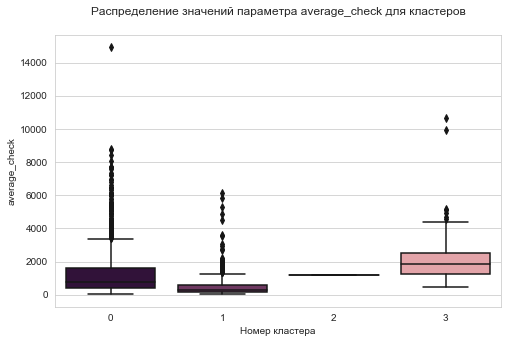

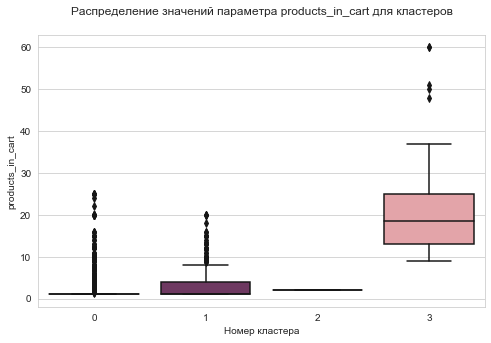

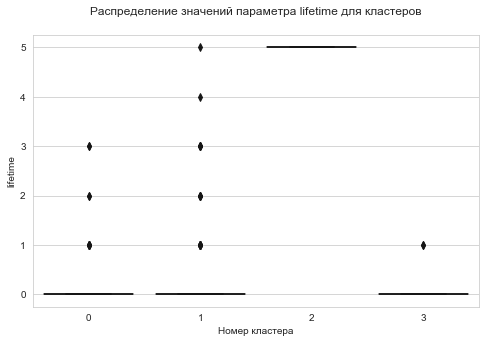

In [145]:
# Графики распределения значений для характеристик
for i in ['average_check', 'products_in_cart', 'lifetime']:
    plt.figure(figsize = (8, 5))    
    ax = sns.boxplot(x = users['cluster'], y = users[i])
    plt.title('Распределение значений параметра {} для кластеров'.format(i), pad = 20)
    plt.xlabel('Номер кластера')
    plt.show()

Распределения подтверждают наши выводы относительно выделенных кластеров, существенных выбросов не наблюдается. Также можно предположить, что клиенты из первого кластера дольше являются покупателями в магазине, чем из других кластеров.

### Проверка гипотезы о значимости различий среднего чека выделенных кластеров

Проверим значимость различий средних чеков выделенных кластеров. Сравнивать будем кластеры 0, 1 и 3, т.к. во втором кластере всего один пользователь.  
Для проверки гипотез будет использоваться `t-критерий Стьюдента`. Из-за множественного сравнения (3 кластера), будем использовать поправку Бонферрони для уменьшения ложноположительных результатов, т.е. уровень значимости  `alpha / 3`.

**Проверка статистической значимости среднего чека заказов кластера 0 и кластера 1.**

*H0: Средние чеки заказов кластера 0 и кластера 1 равны.*

In [146]:
# T-тест
t_test(users.query('cluster == 0')['average_check'],
       users.query('cluster == 1')['average_check'],
       alpha / 3)

P-value: 8.011749397344041e-69
Отвергаем H0: разница между средними чеками сегментов статистически значима


**Проверка статистической значимости среднего чека заказов кластера 0 и кластера 3.**

*H0: Средние чеки заказов кластера 0 и кластера 2 равны.*

In [147]:
# T-тест
t_test(users.query('cluster == 0')['average_check'],
       users.query('cluster == 3')['average_check'],
       alpha / 3)

P-value: 1.1197195380811638e-07
Отвергаем H0: разница между средними чеками сегментов статистически значима


**Проверка статистической значимости среднего чека заказов кластера 1 и кластера 3.**

*H0: Средние чеки заказов кластера 1 и кластера 2 равны.*

In [148]:
# T-тест
t_test(users.query('cluster == 1')['average_check'],
       users.query('cluster == 3')['average_check'],
       alpha / 3)

P-value: 1.5428054451491683e-17
Отвергаем H0: разница между средними чеками сегментов статистически значима


Разницы в средних чеках по всем кластерам статистически значимы.

<a id='step7'></a>
## Общий вывод

Условно всех клиентов интернет-магазина можно разделить на две большие группы: оптовые покупатели и розничные покупатели.  
Розничных покупателей можно разделить на 2 группы на основе сезонов и на 3 группы на основе всех характеристик пользователя. 

**Оптовые покупатели**

Общие характеристики оптовых покупателей:
* оптовые заказы составляют *2,5* процента от общего числа заказов, доля выручки по оптовым заказам  - 29%;
* средний чек оптового заказа - 17422.19;
* свойственна закупка товаров одной категории, связанной с родом предпринимательской деятельности.

Персонализированные предложения для оптовых покупателей:
* с учетом сферы предпринимательской деятельности предоставить скидки на соответствующие сфере товары при заказе от n-количества однотипных товаров;
* рекомендательная система товаров на основе сферы предпринимательской деятельности;
* почтовые рассылки о новый товарах, связанных с родом деятельности клиента;
* на основе анализа и определения часто соседствующих товаров в корзинах оптовых покупателей и объединения их в группы, при добавлении одного товара из группы, предлагать пользователю другие товары данной группы.

**Розничные покупатели**

1. Сегментация клиентов на **основе сезонов**.

*Клиенты, совершающие заказы в осенне-зимний период (с октября по январь).*

* наиболее выгодный период для магазина: средний чек покупок в данный период выше, чем в остальные месяцы;
* в этот период покупателей меньше интересуют растения и рассада (ключевая категория в магазине) и больше интересуют покупки других категорий, особенно повышается интерес к категории "Декор интерьера";
* из категории товаров "Растения и рассада" покупателей больше всего привлекают домашние растения.

*Клиенты, совершающие заказы в весенне-летний период (с февраля по сентябрь).*
* клиентов больше всего интересует категория "Растения и рассада", особенно растения на посадку.

Персонализированных предложения для покупателей с учетом сезона:

* почтовая рассылка сезонных товаров;
* рекомендательная система товаров исходя из популярности товара в данном сезоне;
* предложения пользователям особых условий покупки популярных в данный период товаров:
    * акции по типу 2 по цене 1, купи n-товаров категории и получи 1 бесплатно;
    * "пакеты" товаров (набор товаров одной категории по специальной цене).  
    
2. Сегментация клиентов **на основе всех характеристик**.

*1 группа (`кластер 0` - `users_by_clusters['cluster_0']`) - тратят средне, покупают различные товары в маленьких количествах*:
* самая обширная группа покупателей;
* средний чек составляет 1243;
* покупают товары различных категорий (в основном, не растения).

*2 группа (`кластер 1` - `users_by_clusters['cluster_1']`) - тратят мало, покупают растения в маленьких количествах*.
* самый маленький средний чек - 487;
* в основном покупают товары категории "Растения и рассада";
* в среднем около 3 товара в корзине.

*3 группа (`кластер 3` - `users_by_clusters['cluster_2']`) - закупают много растений на большую сумму*.
* самая маленькая группа покупателей;
* самый большой средний чек ( = 2191);
* среднее число товаров в корзине - 20 шт.;
* в основном покупают товары категории "Растения и рассада".

Предложения:  

Для покупателей `группы 3` характерна массовость закупки, поэтому скорее всего клиентов данного сегмента заинтересуют скидки на большое количество однотипных товаров, наборы и комплекты товаров из категории "Растения и рассада". Данные акции можно отображать как на главной странице магазина, так и осуществлять почтовую рассылку. 

Для клиентов `2` и `3 группы` можно сделать рекомендательную систему товаров, а также рассылку новых товаров соответствующих группе категорий.
